# INFO623 FINAL PROJECT SPRING 2021/2021

## Mary M Lucas

### Co-Authorship Network Analysis - AI Fairness in Healthcare


Query: "AI AND fairness AND healthcare" OR "AI AND bias AND healthcare" - search in Title, Abstract, or Keywords fields.

Data Source:
- SCOPUS: 147 Results from 2008 to 2023
- Web of Science: 104 results from 2016 to 2023


## PART 1 - ANALYZE AUTHOR COLLABORATIONS

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from itertools import combinations
from itertools import islice
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. Compare the two datasets and merge if necessary

In [3]:
scopus_data = pd.read_csv('./data/AI_fairness-Scopus.csv')
wos_data = pd.read_csv('./data/AI_fairness-WoS.txt', sep='\t')

In [4]:
print(scopus_data.shape)
print(wos_data.shape)

(147, 30)
(105, 70)


In [5]:
scopus_data.head(2)

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,...,ISSN,ISBN,CODEN,PubMed ID,Language of Original Document,Document Type,Publication Stage,Open Access,Source,EID
0,"Kaur D., Uslu S., Rittichier K.J., Durresi A.",57209112293;57202760194;57232777900;57207529486;,Trustworthy Artificial Intelligence: A Review,2023,ACM Computing Surveys,55,2,3491209,NaN,NaN,...,03600300,NaN,ACSUE,NaN,English,Review,Final,NaN,Scopus,2-s2.0-85128190943
1,"Meng C., Trinh L., Xu N., Enouen J., Liu Y.",57202426214;57219738459;57208483219;5721219631...,Interpretability and fairness evaluation of de...,2022,Scientific Reports,12,1,7166,NaN,NaN,...,20452322,NaN,NaN,35504931.0,English,Article,Final,"All Open Access, Gold, Green",Scopus,2-s2.0-85129293939


In [6]:
wos_data.head(2)

,PT,AU,BA,BE,GP,AF,BF,CA,TI,SO,...,WC,WE,SC,GA,PM,OA,HC,HP,DA,UT
0,C,"Ahmad, MA; Patel, A; Eckert, C; Kumar, V; Tere...",NaN,NaN,ASSOC COMP MACHINERY,"Ahmad, Muhammad Aurangzeb; Patel, Arpit; Ecker...",NaN,NaN,Fairness in Machine Learning for Healthcare,KDD '20: PROCEEDINGS OF THE 26TH ACM SIGKDD IN...,...,"Computer Science, Artificial Intelligence; Com...",Conference Proceedings Citation Index - Scienc...,Computer Science,BS6LS,NaN,NaN,NaN,NaN,2022-06-02,WOS:000749552303070
1,C,"Ahmad, MA; Overman, S; Allen, C; Kumar, V; Ter...",NaN,NaN,ASSOC COMP MACHINERY,"Ahmad, Muhammad Aurangzeb; Overman, Steve; All...",NaN,NaN,Software as a Medical Device: Regulating AI in...,KDD '21: PROCEEDINGS OF THE 27TH ACM SIGKDD CO...,...,"Computer Science, Artificial Intelligence; Com...",Conference Proceedings Citation Index - Scienc...,Computer Science,BS6LU,NaN,NaN,NaN,NaN,2022-06-02,WOS:000749556804007


Explanation of column titles on WoS result set obtained from https://images.webofknowledge.com/images/help/WOS/hs_wos_fieldtags.html

In [7]:
# rename some of the columns in WoS to compare with the SCOPUS results
wos_data.rename(columns={"AU": "Authors", "C3": "Affiliations", "TI": "Title", "SO": "Source title", "PU": "Publisher"}, inplace=True)

In [8]:
scopus_data_trunc = scopus_data[['Authors', 'Title', 'Affiliations', 'Source title', 'Publisher']]
wos_data_trunc = wos_data[['Authors', 'Title', 'Affiliations', 'Source title', 'Publisher']]

In [9]:
# check if any of the titles in SCOPUS are not in WoS
scopus_data_trunc[~scopus_data_trunc['Title'].isin(wos_data_trunc['Title'])].dropna()

,Authors,Title,Affiliations,Source title,Publisher
4,"Bertl M., Ross P., Draheim D.",A survey on AI and decision support systems in...,"Department of Health Technologies, Tallinn Uni...",Expert Systems with Applications,Elsevier Ltd
6,London A.J.,Artificial intelligence in medicine: Overcomin...,Department of Philosophy and Center for Ethics...,Cell Reports Medicine,Cell Press
7,"Dey S., Chakraborty P., Kwon B.C., Dhurandhar ...",Human-centered explainability for life science...,"Center for Computational Health, IBM Thomas J....",Patterns,Cell Press
8,"Ehsan U., Wintersberger P., Liao Q.V., Watkins...",Human-Centered Explainable AI (HCXAI): Beyond ...,"Georgia Institute of Technology, Atlanta, GA, ...",Conference on Human Factors in Computing Syste...,Association for Computing Machinery
9,"Christou C.D., Tsoulfas G.",Role of three-dimensional printing and artific...,"Department of Transplantation Surgery, Hippokr...",World Journal of Gastrointestinal Oncology,Baishideng Publishing Group Inc
...,...,...,...,...,...
139,"Kerr D., Klonoff D.C.",Digital Diabetes Data and Artificial Intellige...,"Sansum Diabetes Research Institute, Santa Barb...",Journal of Diabetes Science and Technology,SAGE Publications Inc.
142,"Rega M.L., Calabrese C., Tortorella P., de Wau...",The Adherence's indicators of cancer patients ...,Corso di Laurea magistrale scienze infermieris...,Professioni infermieristiche,NLM (Medline)
143,Steels L.,What Needs to Be Done to Ensure the Ethical Us...,"ICREA, Institut de Biologia Evolutiva (UPF-CSI...",Frontiers in Artificial Intelligence and Appli...,IOS Press
144,"Naik S., Srivastava M.",A study on relevance of professional training ...,"Symbiosis Institute of Business Management, Be...",Indian Journal of Public Health Research and D...,Institute of Medico-Legal Publications


In [10]:
# check if any of the titles in WoS are not in SCOPUS
wos_data_trunc[~wos_data_trunc['Title'].isin(scopus_data_trunc['Title'])].dropna()

,Authors,Title,Affiliations,Source title,Publisher


**Therefore all the articles in the SCOPUS dataset are also in the WoS dataset so no need to merge the results.  Will limit analysis to the SCOPUS dataset.**

### 2. Exploratory data analysis and preprocessing


In [11]:
data = pd.read_csv('./data/AI_fairness-Scopus.csv')
data.shape

(147, 30)

In [12]:
data.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Volume',
       'Issue', 'Art. No.', 'Page start', 'Page end', 'Page count', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations',
       'Author Keywords', 'Funding Details', 'References', 'Publisher', 'ISSN',
       'ISBN', 'CODEN', 'PubMed ID', 'Language of Original Document',
       'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')

In [13]:
data.isnull().sum(axis = 0)

Authors                            0
Author(s) ID                       0
Title                              0
Year                               0
Source title                       0
Volume                            40
Issue                             77
Art. No.                          99
Page start                        60
Page end                          62
Page count                       144
Cited by                          51
DOI                                8
Link                               0
Affiliations                       3
Authors with affiliations          3
Author Keywords                   33
Funding Details                  101
References                        10
Publisher                          1
ISSN                              30
ISBN                             103
CODEN                            108
PubMed ID                         90
Language of Original Document      0
Document Type                      0
Publication Stage                  0
O

In [14]:
# check for duplicate titles
data['Title'].nunique()

146

In [15]:
data['EID'].nunique()

147

In [16]:
data[data.duplicated(['Title'], keep=False)]

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,...,ISSN,ISBN,CODEN,PubMed ID,Language of Original Document,Document Type,Publication Stage,Open Access,Source,EID
75,[No author name available],[No author id available],12th International Conference on Digital Human...,2021,Lecture Notes in Computer Science (including s...,12777 LNCS,NaN,NaN,NaN,NaN,...,03029743,9.783031e+12,NaN,NaN,English,Conference Review,Final,NaN,Scopus,2-s2.0-85112172800
76,[No author name available],[No author id available],12th International Conference on Digital Human...,2021,Lecture Notes in Computer Science (including s...,12778 LNCS,NaN,NaN,NaN,NaN,...,03029743,9.783031e+12,NaN,NaN,English,Conference Review,Final,NaN,Scopus,2-s2.0-85112042461


This duplicated title is missing author names so will just ignore it.

In [17]:
data.groupby('Year').size().sort_values(ascending=False)

Year
2021    57
2020    33
2022    29
2019    20
2018     4
2008     1
2015     1
2017     1
2023     1
dtype: int64

In [18]:
by_years = data.groupby('Year').size().sort_values(ascending=False).to_frame(name='count').reset_index()
by_years.sort_values('Year')

,Year,count
5,2008,1
6,2015,1
7,2017,1
4,2018,4
3,2019,20
1,2020,33
0,2021,57
2,2022,29
8,2023,1


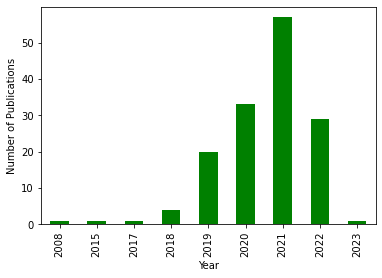

In [19]:
by_years.sort_values('Year').plot.bar(x='Year', color='g')
plt.ylabel("Number of Publications")
plt.xlabel("Year")
plt.gca().get_legend().remove()
plt.show()

In [20]:
data['author_list'] = data['Authors'].str.split(',')
data['author_id_list'] = data['Author(s) ID'].str.split(';')

In [21]:
#create mapping between authors and IDs if needed
def cmp(x, y):
    mapping = dict(zip(x, y))
    return mapping


data['author_id_mapping'] = data.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)

In [22]:
# create df with just titles and author fields
pairs = data[['Title', 'Authors']]
pairs

,Title,Authors
0,Trustworthy Artificial Intelligence: A Review,"Kaur D., Uslu S., Rittichier K.J., Durresi A."
1,Interpretability and fairness evaluation of de...,"Meng C., Trinh L., Xu N., Enouen J., Liu Y."
2,Artificial intelligence in diagnosis of knee o...,"Lee L.S., Chan P.K., Wen C., Fung W.C., Cheung..."
3,Quality assessment standards in artificial int...,"Jayakumar S., Sounderajah V., Normahani P., Ha..."
4,A survey on AI and decision support systems in...,"Bertl M., Ross P., Draheim D."
...,...,...
142,The Adherence's indicators of cancer patients ...,"Rega M.L., Calabrese C., Tortorella P., de Wau..."
143,What Needs to Be Done to Ensure the Ethical Us...,Steels L.
144,A study on relevance of professional training ...,"Naik S., Srivastava M."
145,Clinicians' Implicit and explicit attitudes ab...,"Sabin J.A., Moore K., Noonan C., Lallemand O.,..."


In [23]:
# create author author pairs for each paper
paired = (data.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

In [24]:
paired

,Title,Authors
0,Trustworthy Artificial Intelligence: A Review,"(Kaur D., Uslu S.)"
1,Trustworthy Artificial Intelligence: A Review,"(Kaur D., Rittichier K.J.)"
2,Trustworthy Artificial Intelligence: A Review,"(Kaur D., Durresi A.)"
3,Trustworthy Artificial Intelligence: A Review,"( Uslu S., Rittichier K.J.)"
4,Trustworthy Artificial Intelligence: A Review,"( Uslu S., Durresi A.)"
...,...,...
2365,Clinicians' Implicit and explicit attitudes ab...,"( Moore K., Buchwald D.)"
2366,Clinicians' Implicit and explicit attitudes ab...,"( Noonan C., Lallemand O.)"
2367,Clinicians' Implicit and explicit attitudes ab...,"( Noonan C., Buchwald D.)"
2368,Clinicians' Implicit and explicit attitudes ab...,"( Lallemand O., Buchwald D.)"


In [25]:
# how many times does each pairing appear
paired.groupby('Authors').size().sort_values(ascending=False)

Authors
( Kumar V.,  Teredesai A.)           4
( Pahlevan N.M.,  Pahlevan N.M.)     3
(Rinderknecht D.,  Pahlevan N.M.)    3
(Ahmad M.A.,  Eckert C.)             3
(Ahmad M.A.,  Kumar V.)              3
                                    ..
( Kitas G.D.,  Kalra M.K.)           1
( Kitas G.D.,  Johri A.M.)           1
( Kitas G.D.,  Faa G.)               1
( Kimpe T.,  Stoyanov D.)            1
(von Gerich H.,  Topaz M.)           1
Length: 2306, dtype: int64

In [26]:
# create a dataframe for creating the graph, will use the count as edge weights
df = paired.groupby('Authors').size().to_frame(name = 'count').reset_index()

In [27]:
# split the pairs of authors into two columns
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df[col] = df['Authors'].apply(lambda location: location[n])

In [28]:
df.sort_values('count',ascending=False)

,Authors,count,author_0,author_1
808,"( Kumar V., Teredesai A.)",4,Kumar V.,Teredesai A.
1204,"( Pahlevan N.M., Pahlevan N.M.)",3,Pahlevan N.M.,Pahlevan N.M.
2199,"(Rinderknecht D., Pahlevan N.M.)",3,Rinderknecht D.,Pahlevan N.M.
1790,"(Ahmad M.A., Eckert C.)",3,Ahmad M.A.,Eckert C.
1792,"(Ahmad M.A., Kumar V.)",3,Ahmad M.A.,Kumar V.
...,...,...,...,...
765,"( Kitas G.D., Kalra M.K.)",1,Kitas G.D.,Kalra M.K.
764,"( Kitas G.D., Johri A.M.)",1,Kitas G.D.,Johri A.M.
763,"( Kitas G.D., Faa G.)",1,Kitas G.D.,Faa G.
762,"( Kimpe T., Stoyanov D.)",1,Kimpe T.,Stoyanov D.


### 3. Network creation and analysis

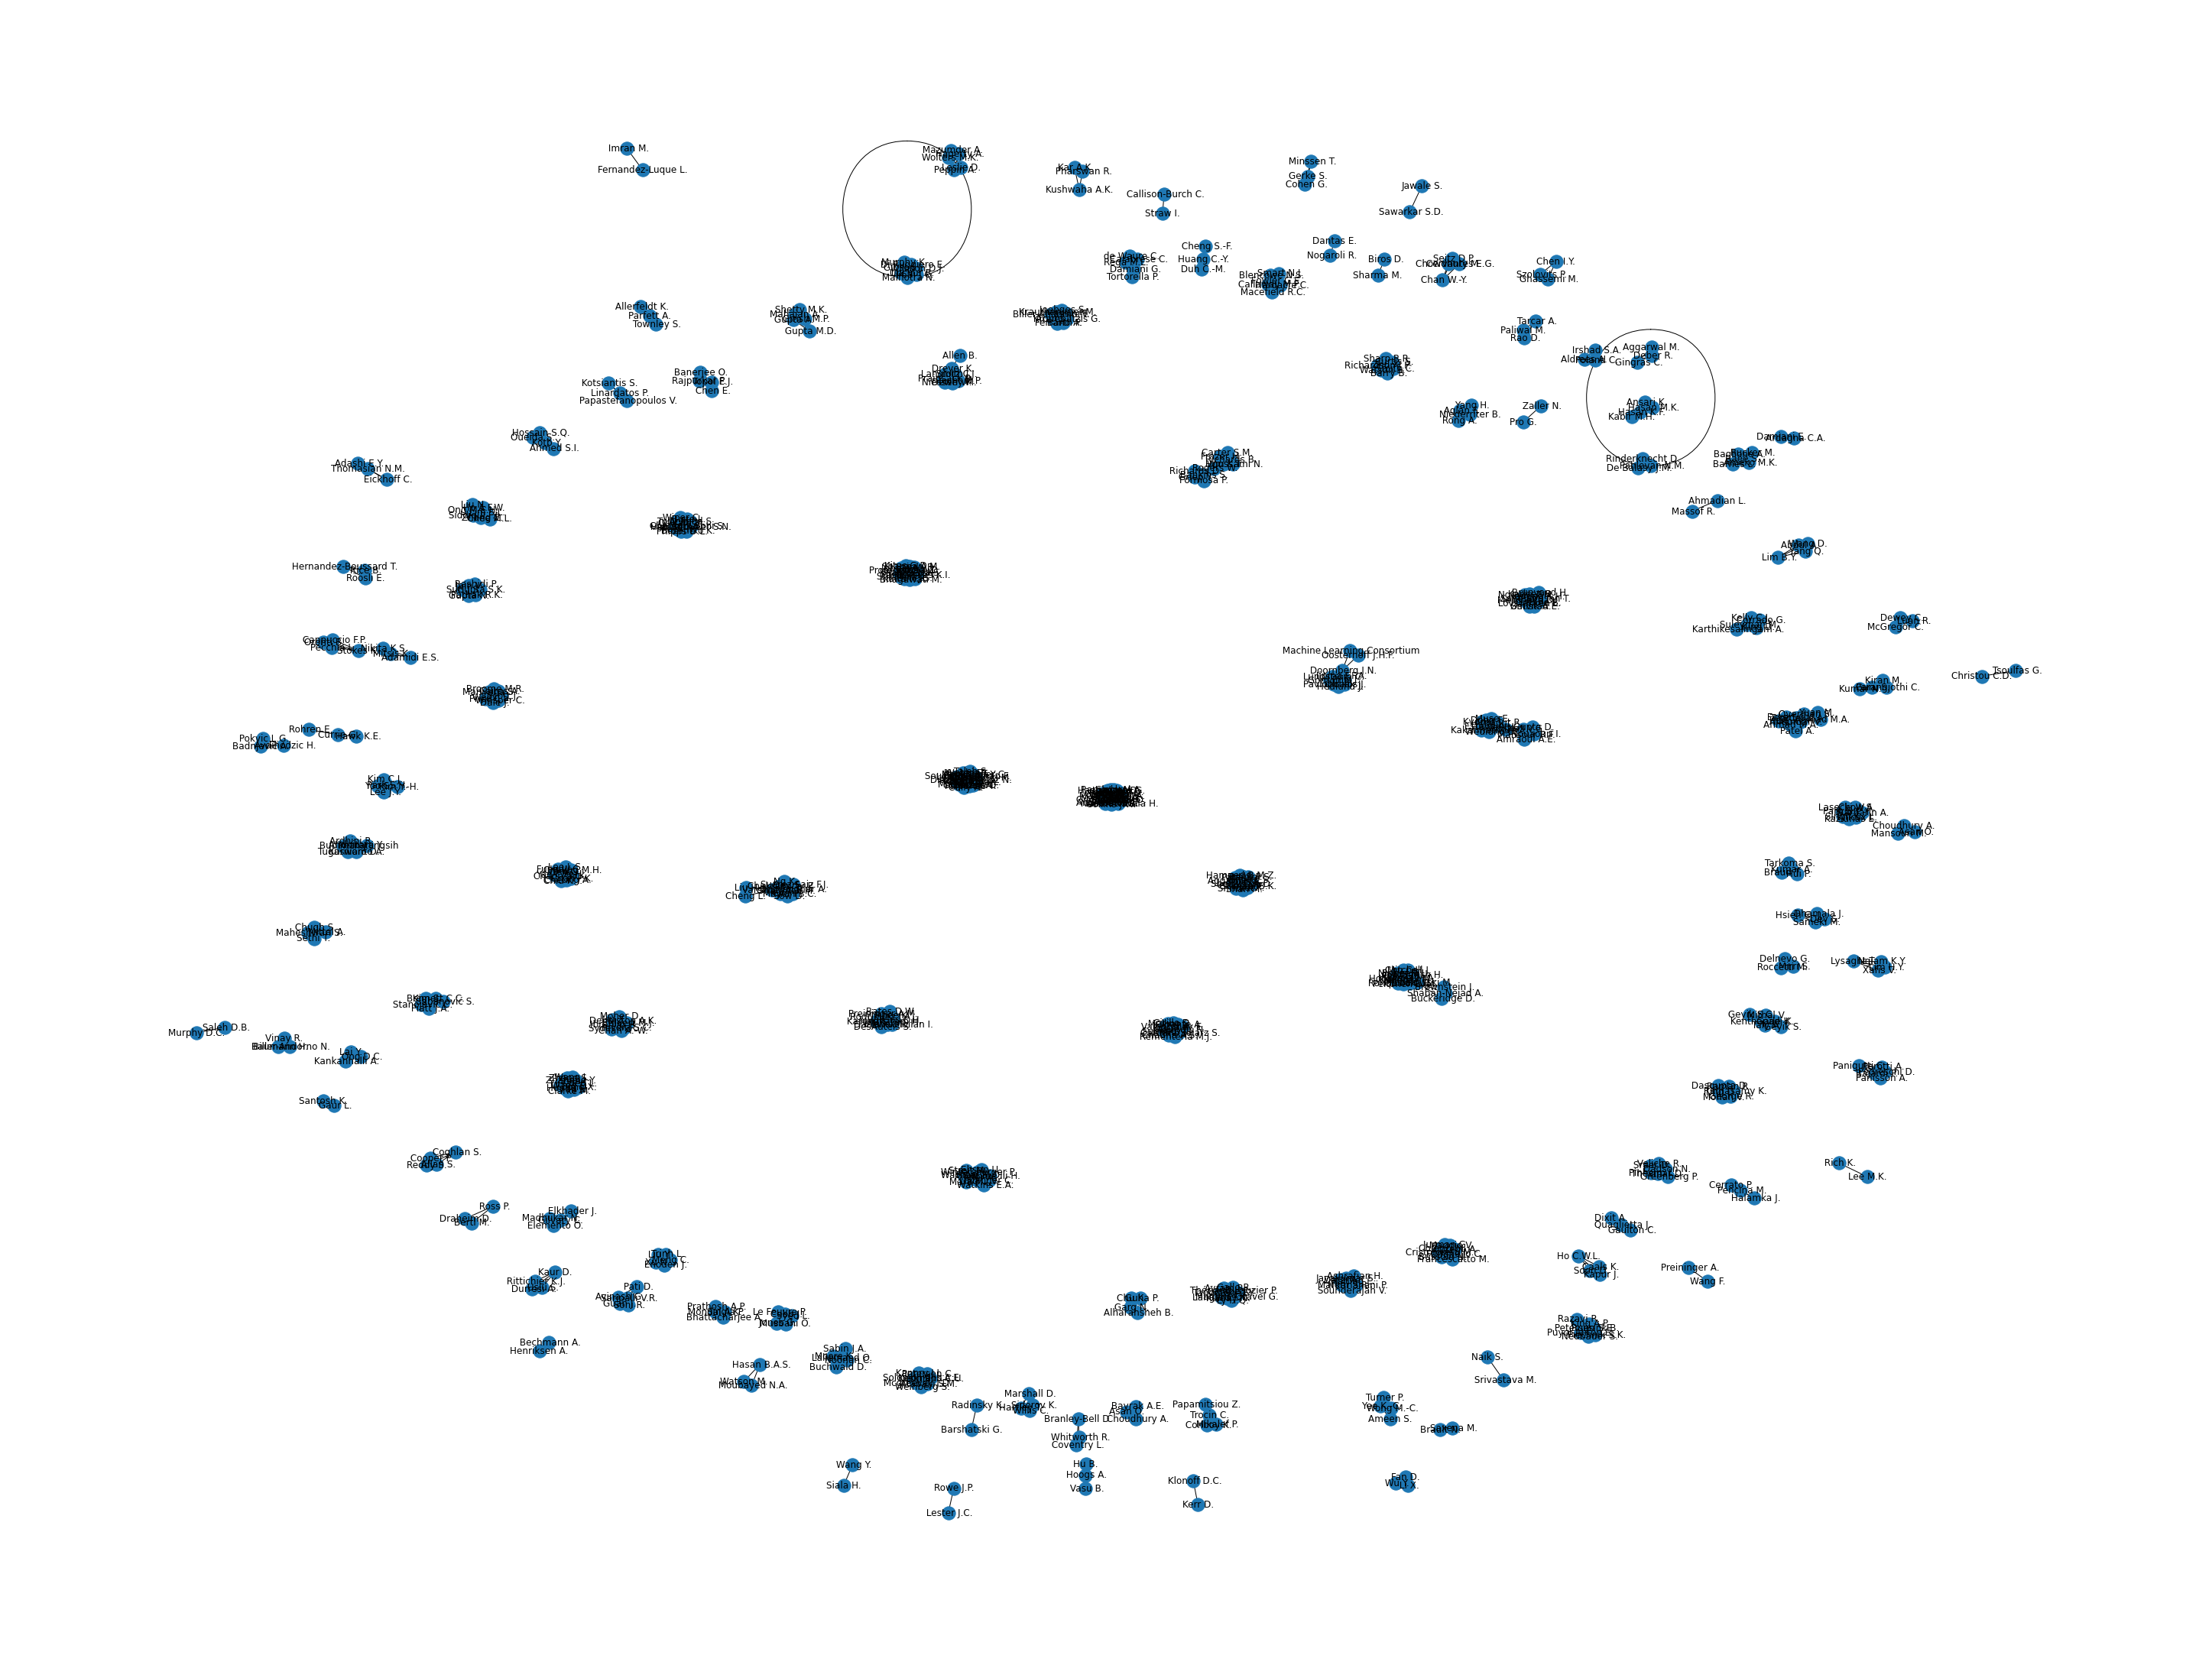

In [29]:
# initial graph
plt.figure(figsize = (40, 30))

G = nx.from_pandas_edgelist(df, 'author_0', 'author_1', edge_attr=True)
nx.draw(G, with_labels=True)

In [30]:
# why the loops?

df.loc[df['author_0'] == df['author_1']]

,Authors,count,author_0,author_1
950,"( Malhotra N., Malhotra N.)",1,Malhotra N.,Malhotra N.
1204,"( Pahlevan N.M., Pahlevan N.M.)",3,Pahlevan N.M.,Pahlevan N.M.


In [31]:
# get rid of these self-loops
df = df[df['author_0'] != df['author_1']]

In [32]:
df.shape
df_scopus1 = df[['author_0', 'author_1', 'count']]
df_scopus1.to_csv('scopus_main.csv')


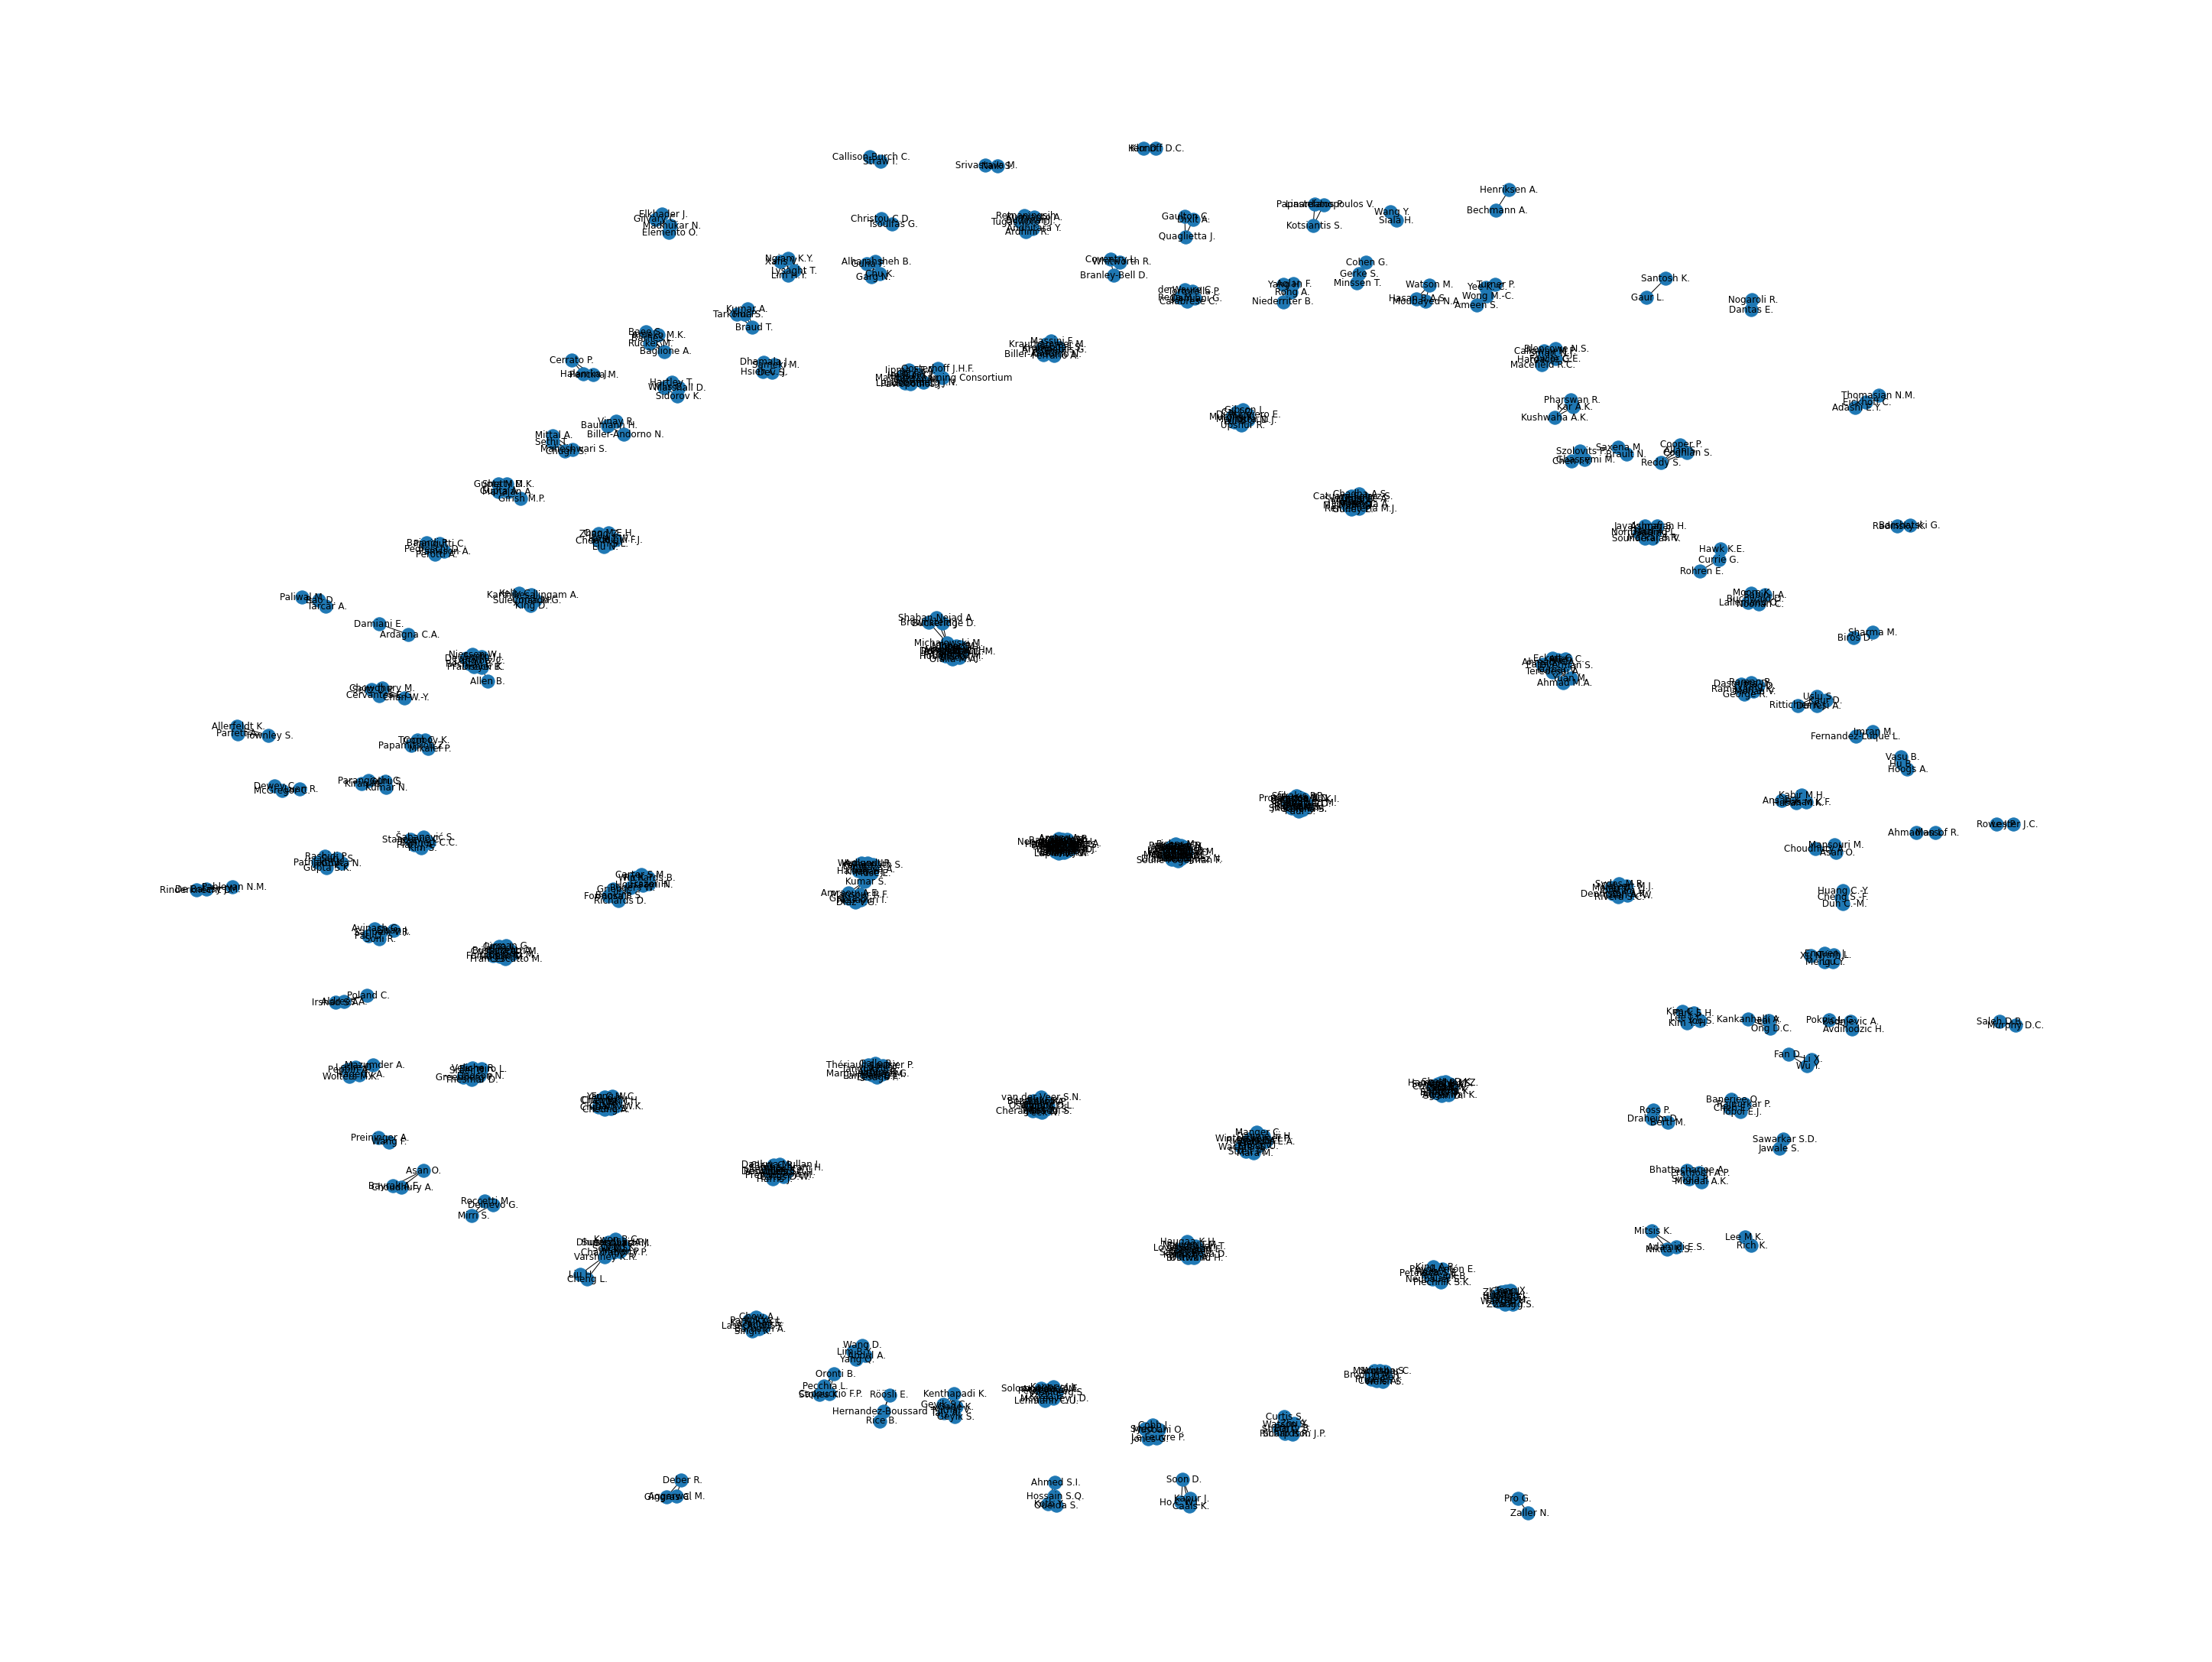

In [33]:
# recreate graph
plt.figure(figsize = (40, 30))

G = nx.from_pandas_edgelist(df, 'author_0', 'author_1', edge_attr=True)
nx.draw(G, with_labels=True)

In [34]:
print('Number of components in {}: {}'.format(G, nx.number_connected_components(G)))

Number of components in Graph with 637 nodes and 2300 edges: 117


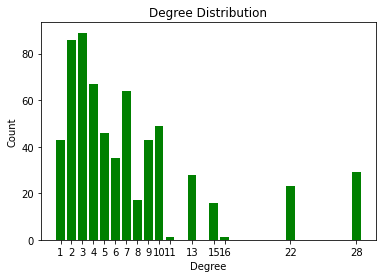

In [35]:
# degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
plt.bar(deg, cnt, width=0.80, color='g')
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xticks(deg)
plt.xlabel("Degree")
plt.show()

In [36]:
# network density
nx.density(G)

0.011354324022787635

In [37]:
nx.average_degree_connectivity(G)

{3: 3.235955056179775,
 13: 12.887362637362637,
 9: 8.705426356589147,
 6: 6.057142857142857,
 7: 7.1875,
 5: 5.339130434782609,
 4: 4.164179104477612,
 28: 28.0,
 8: 8.294117647058824,
 2: 2.1744186046511627,
 10: 9.816326530612244,
 22: 22.0,
 15: 15.0,
 16: 11.125,
 11: 7.7272727272727275,
 1: 1.186046511627907}

In [38]:
# have node size depend on node degree
dict(G.degree()).values()

dict_values([3, 3, 13, 13, 13, 13, 13, 13, 13, 13, 3, 9, 3, 3, 3, 3, 3, 3, 6, 7, 5, 9, 4, 4, 5, 5, 5, 13, 5, 5, 5, 5, 5, 28, 28, 28, 28, 28, 28, 28, 28, 3, 3, 7, 7, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 8, 8, 8, 8, 8, 8, 2, 2, 6, 6, 7, 7, 7, 7, 7, 7, 10, 10, 10, 10, 10, 2, 2, 4, 4, 4, 4, 4, 3, 3, 4, 4, 7, 7, 7, 7, 7, 7, 6, 6, 7, 9, 9, 2, 2, 2, 2, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 3, 3, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 10, 3, 3, 3, 3, 3, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 5, 5, 5, 7, 7, 3, 3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 3, 3, 9, 9, 9, 9, 9, 9, 9, 9, 11, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 10, 10, 10, 10, 10, 10, 4, 4, 4, 4, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 7, 10, 10, 2, 2, 9, 9, 9, 2, 2, 6, 7, 6, 6, 6, 6, 3, 3, 7, 7, 7, 9, 7, 7, 7, 2, 2, 2, 2, 2, 3, 3, 4, 4, 8, 7, 7, 7, 7, 5

In [39]:
#have edge thickness depend on count of collaborations
edgelist = nx.to_edgelist(G)


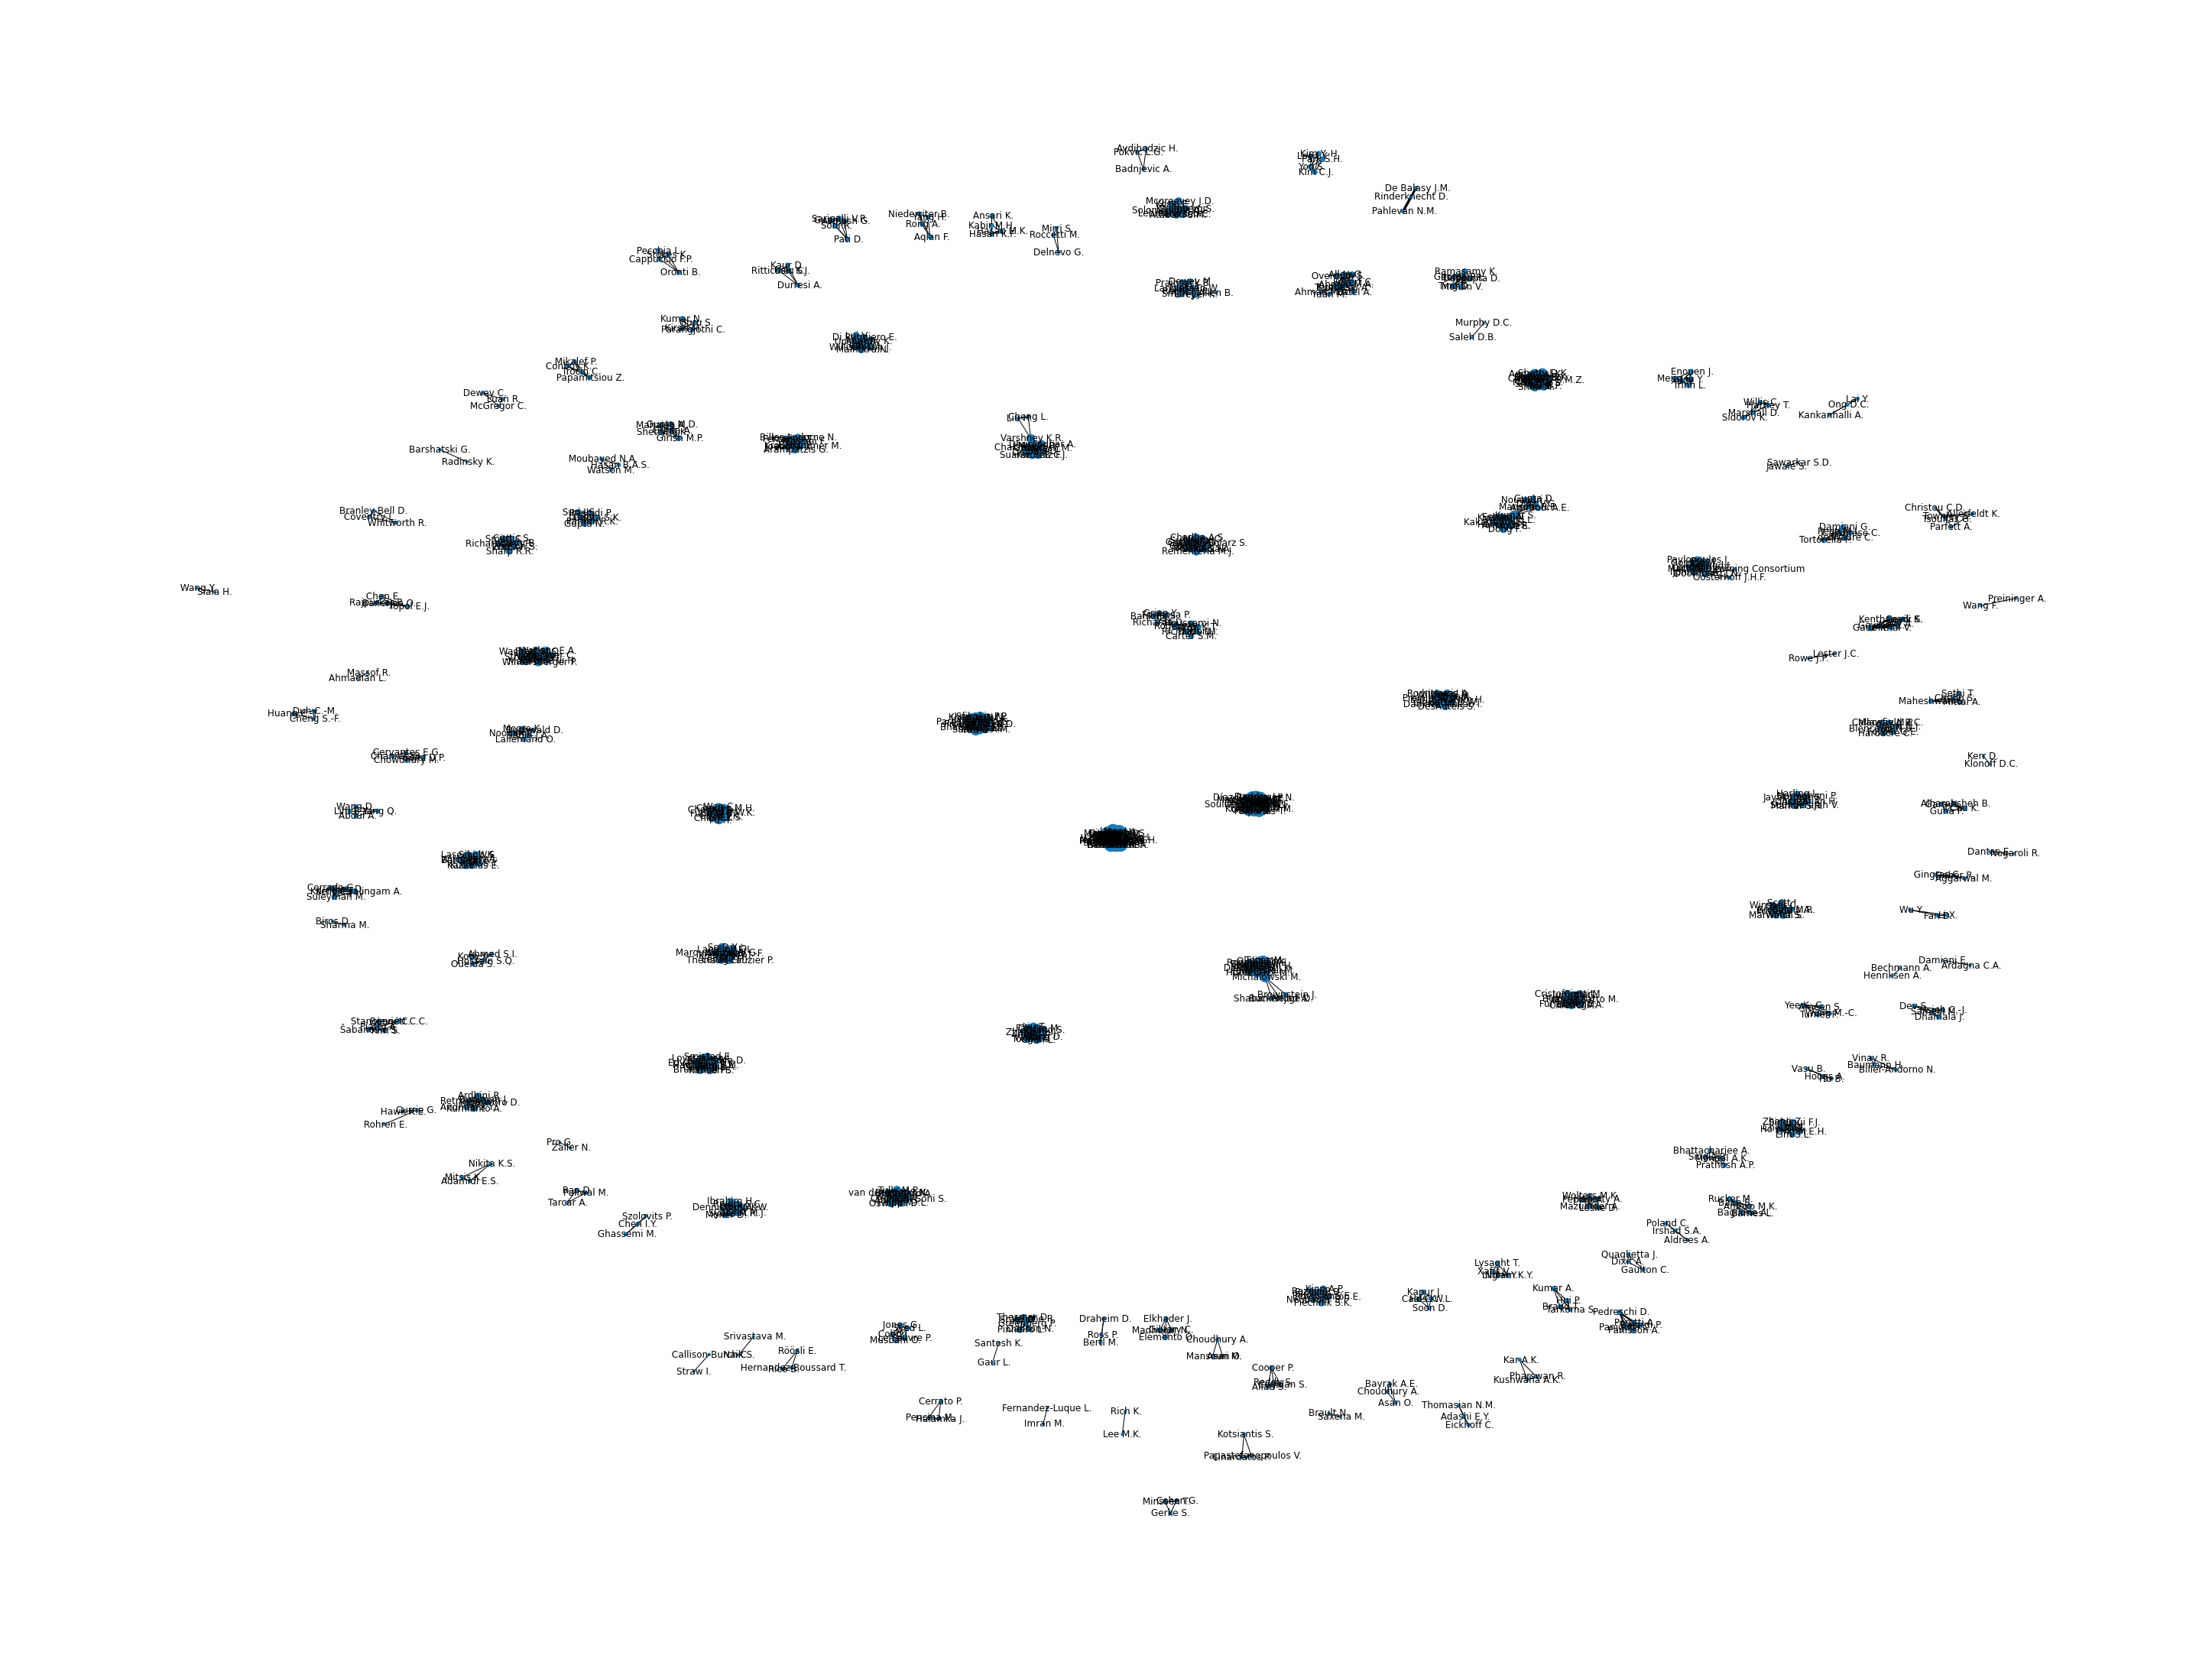

In [40]:
# recreate graph with attributes added
plt.figure(figsize = (40, 30))

G = nx.from_pandas_edgelist(df, 'author_0', 'author_1', edge_attr=True)
nx.draw(G, 
        with_labels=True, 
        node_size = [d*10 for d in dict(G.degree()).values()],
       width = [v[2]['count'] for v in edgelist])

In [41]:
# export graph for import to Gephi
G = nx.from_pandas_edgelist(df, 'author_0', 'author_1')
nx.write_gexf(G, 'scopus1_main.gexf', encoding='utf-8', prettyprint=True, version='1.2draft')

In [42]:
# Gephi graph


### Centrality and other measures

In [43]:
#function to return first n items of dict as a list
def take(n, iterable):
    return list(islice(iterable, n))

In [44]:
# degree centrality
dc_sorted_tuples = sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse=True)
dc_sorted_dict = {k: v for k, v in dc_sorted_tuples}

# show top 5
take(5, dc_sorted_dict.items())

[(' Andrews B.', 0.04402515723270441),
 (' Andrusaite A.', 0.04402515723270441),
 (' Garcia P.', 0.04402515723270441),
 (' Hawkes D.', 0.04402515723270441),
 (' Kelly J.D.', 0.04402515723270441)]

In [45]:
# show top 40
take(40, dc_sorted_dict.items())

[(' Andrews B.', 0.04402515723270441),
 (' Andrusaite A.', 0.04402515723270441),
 (' Garcia P.', 0.04402515723270441),
 (' Hawkes D.', 0.04402515723270441),
 (' Kelly J.D.', 0.04402515723270441),
 (' Kimpe T.', 0.04402515723270441),
 (' Neemuchwala H.', 0.04402515723270441),
 (' Stoyanov D.', 0.04402515723270441),
 (' Arezzo A.', 0.04402515723270441),
 (' Beaulieu Y.', 0.04402515723270441),
 (' Elson D.', 0.04402515723270441),
 (' Giannarou S.', 0.04402515723270441),
 (' Hares L.', 0.04402515723270441),
 (' Jannin P.', 0.04402515723270441),
 (' Jarc A.', 0.04402515723270441),
 (' Laplante G.', 0.04402515723270441),
 (' Levy J.', 0.04402515723270441),
 (' Maier-Hein L.', 0.04402515723270441),
 (' Marz K.', 0.04402515723270441),
 (' Mori K.', 0.04402515723270441),
 (' Ramadorai A.', 0.04402515723270441),
 (' Slack M.', 0.04402515723270441),
 (' Valdastri P.', 0.04402515723270441),
 (' Ghazi A.', 0.04402515723270441),
 (' Hager G.', 0.04402515723270441),
 (' Hashimoto D.', 0.0440251572327

In [46]:
# closeness centrality
cc_sorted_tuples = sorted(nx.closeness_centrality(G).items(), key=lambda item: item[1], reverse=True)
cc_sorted_dict = {k: v for k, v in cc_sorted_tuples}

# show top 5
take(5, cc_sorted_dict.items())

[(' Andrews B.', 0.0440251572327044),
 (' Andrusaite A.', 0.0440251572327044),
 (' Garcia P.', 0.0440251572327044),
 (' Hawkes D.', 0.0440251572327044),
 (' Kelly J.D.', 0.0440251572327044)]

In [47]:
# show top 40
take(40, cc_sorted_dict.items())

[(' Andrews B.', 0.0440251572327044),
 (' Andrusaite A.', 0.0440251572327044),
 (' Garcia P.', 0.0440251572327044),
 (' Hawkes D.', 0.0440251572327044),
 (' Kelly J.D.', 0.0440251572327044),
 (' Kimpe T.', 0.0440251572327044),
 (' Neemuchwala H.', 0.0440251572327044),
 (' Stoyanov D.', 0.0440251572327044),
 (' Arezzo A.', 0.0440251572327044),
 (' Beaulieu Y.', 0.0440251572327044),
 (' Elson D.', 0.0440251572327044),
 (' Giannarou S.', 0.0440251572327044),
 (' Hares L.', 0.0440251572327044),
 (' Jannin P.', 0.0440251572327044),
 (' Jarc A.', 0.0440251572327044),
 (' Laplante G.', 0.0440251572327044),
 (' Levy J.', 0.0440251572327044),
 (' Maier-Hein L.', 0.0440251572327044),
 (' Marz K.', 0.0440251572327044),
 (' Mori K.', 0.0440251572327044),
 (' Ramadorai A.', 0.0440251572327044),
 (' Slack M.', 0.0440251572327044),
 (' Valdastri P.', 0.0440251572327044),
 (' Ghazi A.', 0.0440251572327044),
 (' Hager G.', 0.0440251572327044),
 (' Hashimoto D.', 0.0440251572327044),
 (' Sridhar A.', 0.

In [48]:
# betweenness centrality
bc_sorted_tuples = sorted(nx.betweenness_centrality(G).items(), key=lambda item: item[1], reverse=True)
bc_sorted_dict = {k: v for k, v in bc_sorted_tuples}

# show top 5
take(5, bc_sorted_dict.items())

[(' Kumar S.', 0.0001980884464913584),
 (' Michalowski M.', 0.00019313623532907443),
 (' Rogers W.', 9.90442232456792e-05),
 (' Varshney K.R.', 8.913980092111127e-05),
 (' Doornberg J.N.', 6.933095627197544e-05)]

In [49]:
# show top 5
take(40, bc_sorted_dict.items())

[(' Kumar S.', 0.0001980884464913584),
 (' Michalowski M.', 0.00019313623532907443),
 (' Rogers W.', 9.90442232456792e-05),
 (' Varshney K.R.', 8.913980092111127e-05),
 (' Doornberg J.N.', 6.933095627197544e-05),
 (' Teredesai A.', 3.441786757787352e-05),
 (' Kumar V.', 3.441786757787352e-05),
 (' Dreyer K.', 2.9713266973703756e-05),
 (' Riedl M.O.', 8.913980092111128e-06),
 (' Riener A.', 8.913980092111128e-06),
 (' Liao Q.V.', 8.913980092111128e-06),
 (' Wintersberger P.', 8.913980092111128e-06),
 ('Ehsan U.', 8.913980092111128e-06),
 ('Currie G.', 4.9522111622839596e-06),
 (' Eckert C.', 4.704600604169761e-06),
 ('Ahmad M.A.', 4.704600604169761e-06),
 (' Kenthapadi K.', 1.2380527905709899e-06),
 (' Mithal V.', 1.2380527905709899e-06),
 (' Taly A.', 1.2380527905709899e-06),
 ('Gade K.', 1.2380527905709899e-06),
 (' Allen C.', 9.90442232456792e-07),
 (' Abdul A.', 0.0),
 (' Lim B.Y.', 0.0),
 (' Aggarwal K.', 0.0),
 (' Brahim S.', 0.0),
 (' Chlosta P.', 0.0),
 (' Patil V.', 0.0),
 (' R

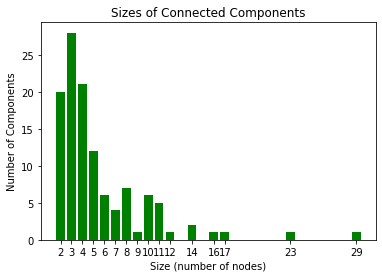

In [50]:
size_sequence = sorted([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])
sizeCount = Counter(size_sequence)
deg, cnt = zip(*sizeCount.items())

plt.bar(deg, cnt, color='g')
plt.title("Sizes of Connected Components")
plt.ylabel("Number of Components")
plt.xticks(deg)
plt.xlabel("Size (number of nodes)")
plt.show()

In [51]:
largest_cc = max(nx.connected_components(G), key=len)

In [52]:
largest_cc

{' Andrews B.',
 ' Andrusaite A.',
 ' Arezzo A.',
 ' Beaulieu Y.',
 ' Elson D.',
 ' Garcia P.',
 ' Ghazi A.',
 ' Giannarou S.',
 ' Hager G.',
 ' Hares L.',
 ' Hashimoto D.',
 ' Hawkes D.',
 ' Jannin P.',
 ' Jarc A.',
 ' Kelly J.D.',
 ' Kimpe T.',
 ' Laplante G.',
 ' Levy J.',
 ' Maier-Hein L.',
 ' Marcus H.J.',
 ' Marz K.',
 ' Mori K.',
 ' Neemuchwala H.',
 ' Ramadorai A.',
 ' Slack M.',
 ' Sridhar A.',
 ' Stoyanov D.',
 ' Valdastri P.',
 'Collins J.W.'}

In [53]:
cluster_coeffs = nx.clustering(G, nodes=None, weight='count')

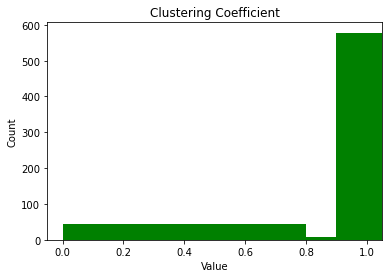

In [54]:
plt.hist(cluster_coeffs.values(), width=0.80, color='g')
plt.title("Clustering Coefficient")
plt.ylabel("Count")
plt.xlabel("Value")
plt.show()

In [55]:
pagerank = nx.pagerank(G, alpha=0.85, weight='count')

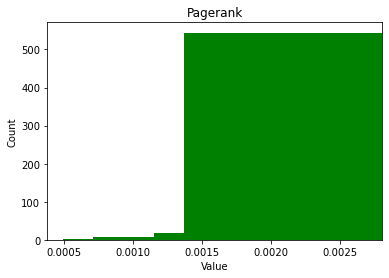

In [56]:
plt.hist(pagerank.values(),  width=0.80, color='g')
plt.title("Pagerank")
plt.ylabel("Count")
plt.xlabel("Value")
plt.show()

### Cliques

In [57]:
def find_cliques_size_k(G, k):
    all_cliques = set()
    for clique in nx.find_cliques(G):
        if len(clique) == k:
            all_cliques.add(tuple(sorted(clique)))
        elif len(clique) > k:
            for mini_clique in combinations(clique, k):
                all_cliques.add(tuple(sorted(mini_clique)))
    return len(all_cliques)

for k in [1, 2, 3, 4]:
    print(find_cliques_size_k(G, k))

637
2300
9133
39871


In [58]:
nx.enumerate_all_cliques(G)

<generator object enumerate_all_cliques at 0x00000190916EE120>

In [59]:
# find clique counts per actor
cliques_count = nx.number_of_cliques(G)

cl_sorted_tuples = sorted(cliques_count.items(), key=lambda item: item[1], reverse=True)
cl_sorted_dict = {k: v for k, v in cl_sorted_tuples}

# show top 
take(30, cl_sorted_dict.items())

[(' Teredesai A.', 4),
 (' Kumar V.', 4),
 (' Eckert C.', 3),
 ('Ahmad M.A.', 3),
 (' Allen C.', 2),
 (' Kumar S.', 2),
 (' Michalowski M.', 2),
 (' Varshney K.R.', 2),
 (' Riedl M.O.', 2),
 (' Riener A.', 2),
 (' Dreyer K.', 2),
 (' Doornberg J.N.', 2),
 (' Kenthapadi K.', 2),
 (' Mithal V.', 2),
 (' Taly A.', 2),
 (' Liao Q.V.', 2),
 (' Rogers W.', 2),
 (' Wintersberger P.', 2),
 ('Currie G.', 2),
 ('Ehsan U.', 2),
 ('Gade K.', 2),
 (' Abdul A.', 1),
 (' Lim B.Y.', 1),
 (' Aggarwal K.', 1),
 (' Brahim S.', 1),
 (' Chlosta P.', 1),
 (' Patil V.', 1),
 (' Rai B.P.', 1),
 (' Shetty S.', 1),
 (' Smriti K.', 1)]

We see authors Teredesai and Kumar belong to 4 cliques each

In [60]:
nx.cliques_containing_node(G, nodes=' Teredesai A.')

[[' Allen C.',
  ' Kumar V.',
  ' Eckert C.',
  'Ahmad M.A.',
  ' Teredesai A.',
  ' Hu J.'],
 [' Allen C.',
  ' Kumar V.',
  ' Eckert C.',
  'Ahmad M.A.',
  ' Teredesai A.',
  ' Overman S.'],
 [' Teredesai A.', ' Kumar V.', ' Eckert C.', 'Ahmad M.A.', ' Patel A.'],
 [' Teredesai A.', ' Kumar V.', ' Ahmad M.A.', 'Yuan M.']]

In [61]:
nx.cliques_containing_node(G, nodes=' Kumar V.')

[[' Allen C.',
  ' Kumar V.',
  ' Eckert C.',
  'Ahmad M.A.',
  ' Teredesai A.',
  ' Hu J.'],
 [' Allen C.',
  ' Kumar V.',
  ' Eckert C.',
  'Ahmad M.A.',
  ' Teredesai A.',
  ' Overman S.'],
 [' Teredesai A.', ' Kumar V.', ' Eckert C.', 'Ahmad M.A.', ' Patel A.'],
 [' Teredesai A.', ' Kumar V.', ' Ahmad M.A.', 'Yuan M.']]

In [62]:
from networkx.algorithms.community import k_clique_communities

list(k_clique_communities(G, 20))

[frozenset({' Andrews B.',
            ' Andrusaite A.',
            ' Arezzo A.',
            ' Beaulieu Y.',
            ' Elson D.',
            ' Garcia P.',
            ' Ghazi A.',
            ' Giannarou S.',
            ' Hager G.',
            ' Hares L.',
            ' Hashimoto D.',
            ' Hawkes D.',
            ' Jannin P.',
            ' Jarc A.',
            ' Kelly J.D.',
            ' Kimpe T.',
            ' Laplante G.',
            ' Levy J.',
            ' Maier-Hein L.',
            ' Marcus H.J.',
            ' Marz K.',
            ' Mori K.',
            ' Neemuchwala H.',
            ' Ramadorai A.',
            ' Slack M.',
            ' Sridhar A.',
            ' Stoyanov D.',
            ' Valdastri P.',
            'Collins J.W.'}),
 frozenset({' Berry H.',
            ' Cully A.',
            ' Dandoy L.',
            ' Díaz-Rodríguez N.',
            ' Ficher M.',
            ' Grizou J.',
            ' Komorowski M.',
            ' Le Cunff Y.',


In [63]:
teredesai_kumar_cliques = G.subgraph([' Overman S.',
  ' Allen C.',
  'Ahmad M.A.',
  ' Teredesai A.',
  ' Eckert C.',
  ' Kumar V.',
 ' Allen C.',
  ' Hu J.',
  'Ahmad M.A.',
  ' Teredesai A.',
  ' Eckert C.',
  ' Kumar V.',
'Yuan M.', ' Ahmad M.A.', ' Teredesai A.', ' Kumar V.',
 ' Teredesai A.', ' Patel A.', 'Ahmad M.A.', ' Eckert C.', ' Kumar V.'])

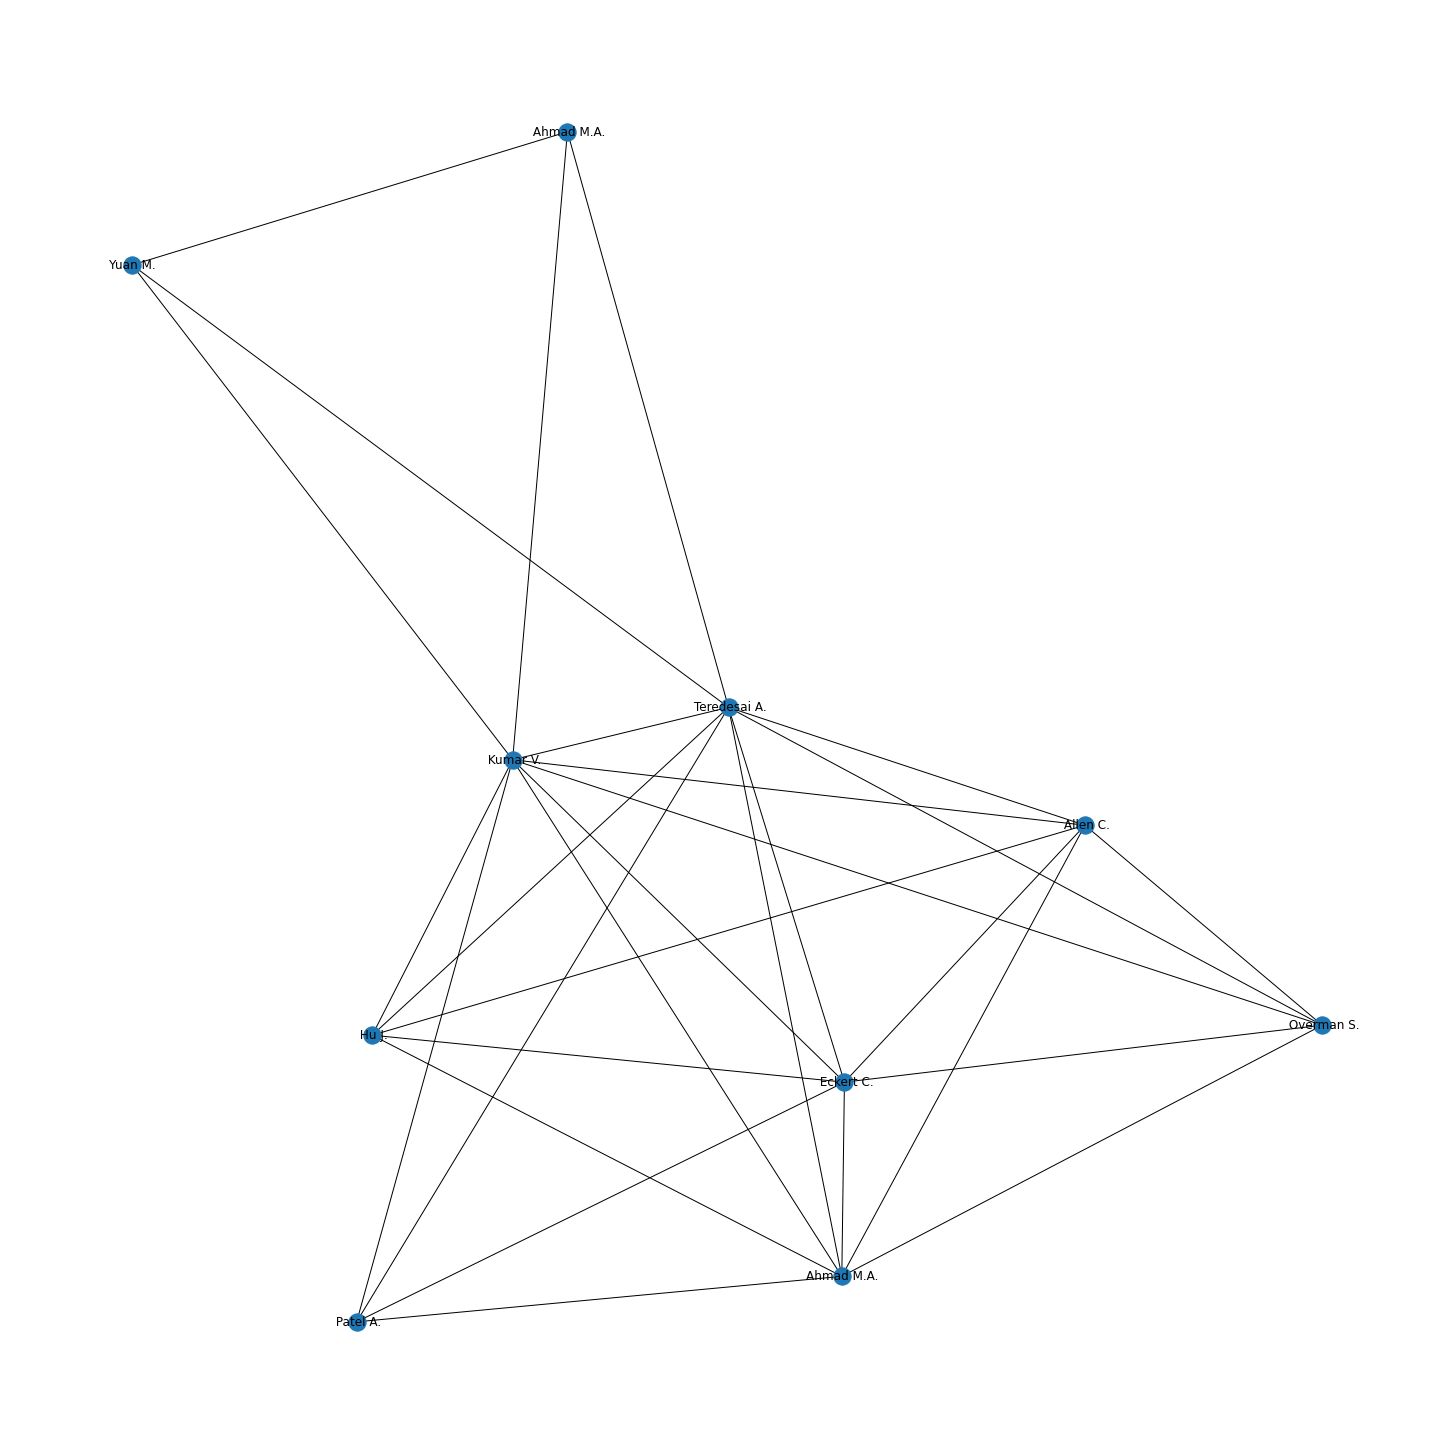

In [64]:
plt.figure(figsize = (20, 20))
nx.draw(teredesai_kumar_cliques, with_labels=True)

In [65]:
# export graph for import to Gephi
nx.write_gexf(teredesai_kumar_cliques, 'scopus1_cliques.gexf', encoding='utf-8', prettyprint=True, version='1.2draft')

## Look at the network across the years

In [66]:
# break analysis down by year
data_2018 = data[data['Year'] == 2018]
data_2019 = data[data['Year'] == 2019]
data_2020 = data[data['Year'] == 2020]
data_2021 = data[data['Year'] == 2021]
data_2022 = data[data['Year'] == 2022]

In [67]:
years = [data_2018, data_2019, data_2020, data_2021, data_2022]
for yr in years:
    print(yr.shape)

(4, 33)
(20, 33)
(33, 33)
(57, 33)
(29, 33)


In [68]:
# preprocess with same steps as above

# create pairs

#------------------
data_2018['author_id_mapping'] = data_2018.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_2018 = (data_2018.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_2018 = paired_2018.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_2018[col] = df_2018['Authors'].apply(lambda location: location[n])
    
#------------------
data_2019['author_id_mapping'] = data_2019.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_2019 = (data_2019.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_2019 = paired_2019.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_2019[col] = df_2019['Authors'].apply(lambda location: location[n])

#-----------------
data_2020['author_id_mapping'] = data_2020.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_2020 = (data_2020.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_2020 = paired_2020.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_2020[col] = df_2020['Authors'].apply(lambda location: location[n])

    
#-----------------
data_2021['author_id_mapping'] = data_2021.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_2021 = (data_2021.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_2021 = paired_2021.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_2021[col] = df_2021['Authors'].apply(lambda location: location[n])
    
#-----------------
data_2022['author_id_mapping'] = data_2022.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_2022 = (data_2022.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_2022 = paired_2022.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_2022[col] = df_2022['Authors'].apply(lambda location: location[n])

In [69]:
years = [df_2018, df_2019, df_2020, df_2021, df_2022]
for yr in years:
    print(yr.shape)

(39, 4)
(158, 4)
(469, 4)
(1037, 4)
(611, 4)


In [70]:
# remove self pairs in any of the dfs
df_2018 = df_2018[df_2018['author_0'] != df_2018['author_1']]
df_2019 = df_2019[df_2019['author_0'] != df_2019['author_1']]
df_2020 = df_2020[df_2020['author_0'] != df_2020['author_1']]
df_2021 = df_2021[df_2021['author_0'] != df_2021['author_1']]
df_2022 = df_2022[df_2022['author_0'] != df_2022['author_1']]


In [71]:
for yr in years:
    print(yr.shape)

(39, 4)
(158, 4)
(469, 4)
(1037, 4)
(611, 4)


In [72]:
# create graphs
G_2018 = nx.from_pandas_edgelist(df_2018, 'author_0', 'author_1')
G_2019 = nx.from_pandas_edgelist(df_2019, 'author_0', 'author_1')
G_2020 = nx.from_pandas_edgelist(df_2020, 'author_0', 'author_1')
G_2021 = nx.from_pandas_edgelist(df_2021, 'author_0', 'author_1')
G_2022 = nx.from_pandas_edgelist(df_2022, 'author_0', 'author_1')




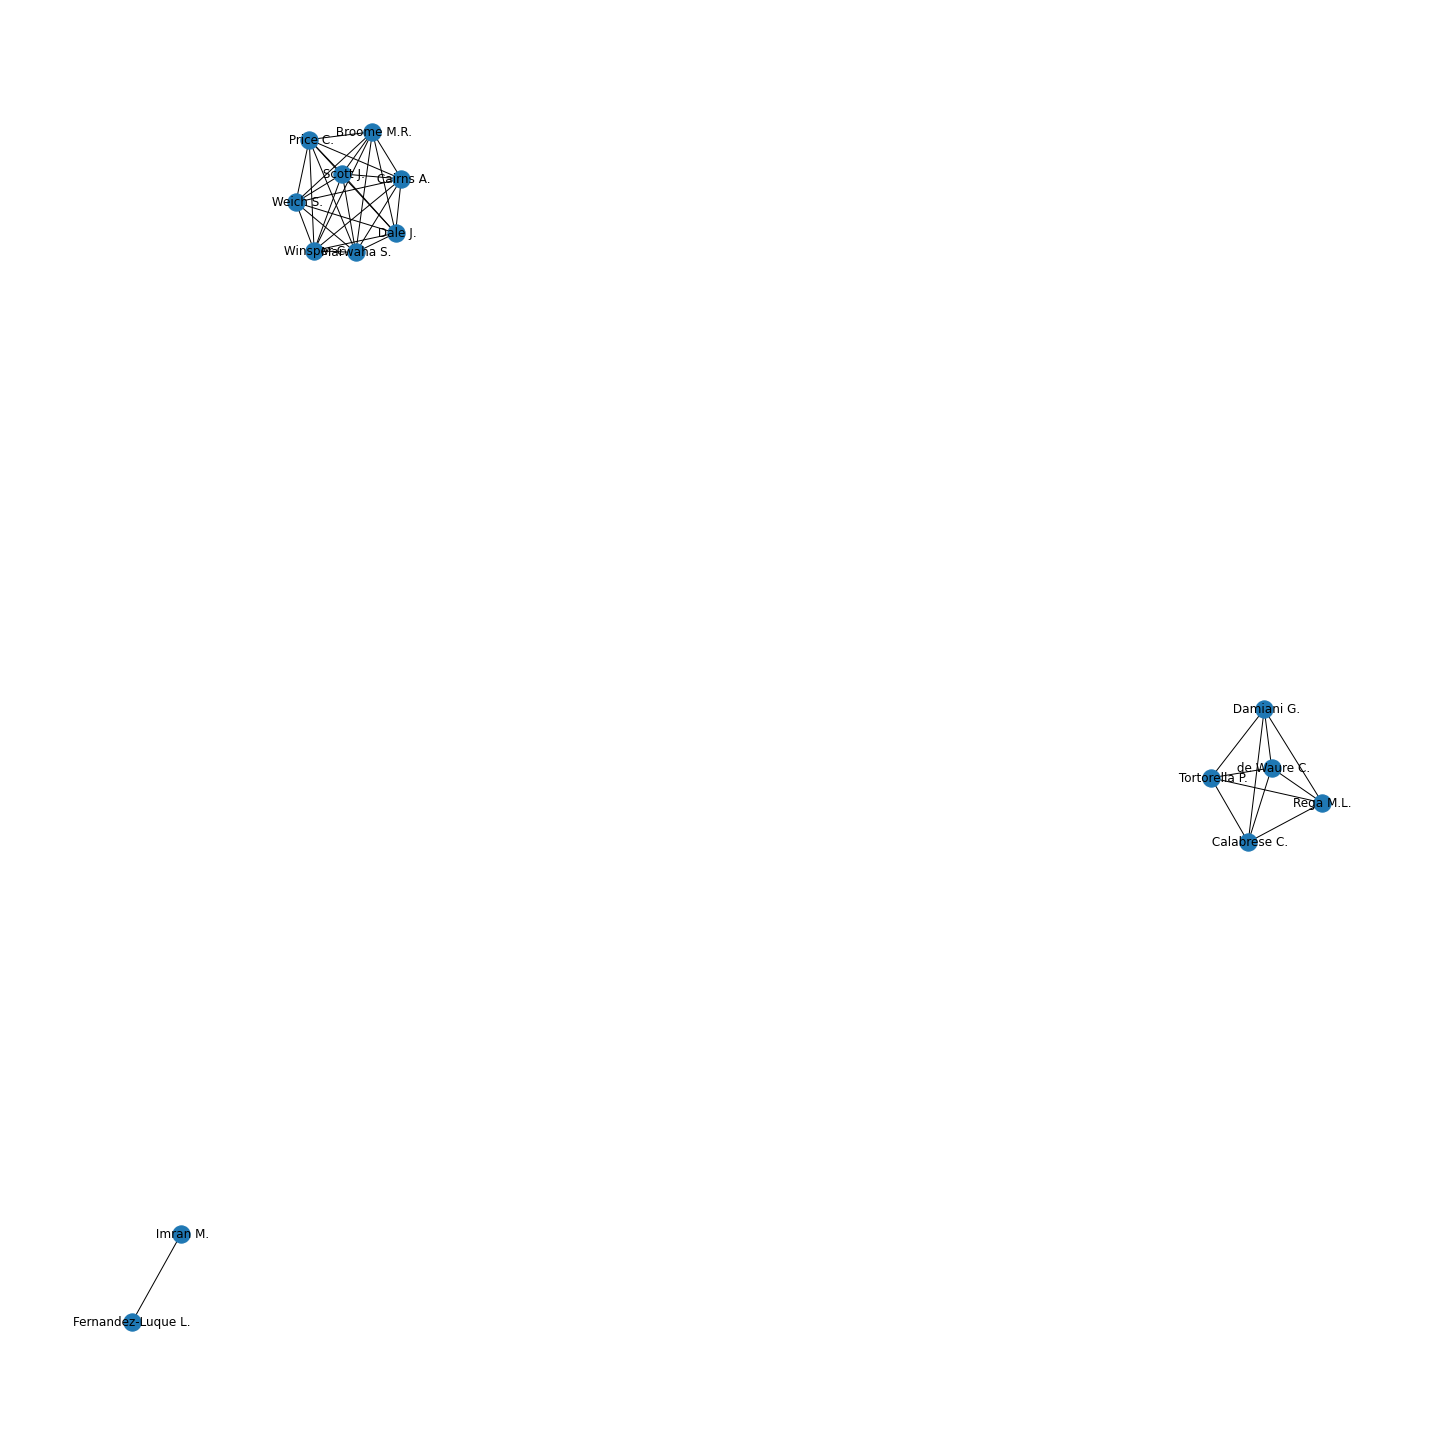

In [73]:
plt.figure(figsize = (20, 20))
nx.draw(G_2018, with_labels=True)

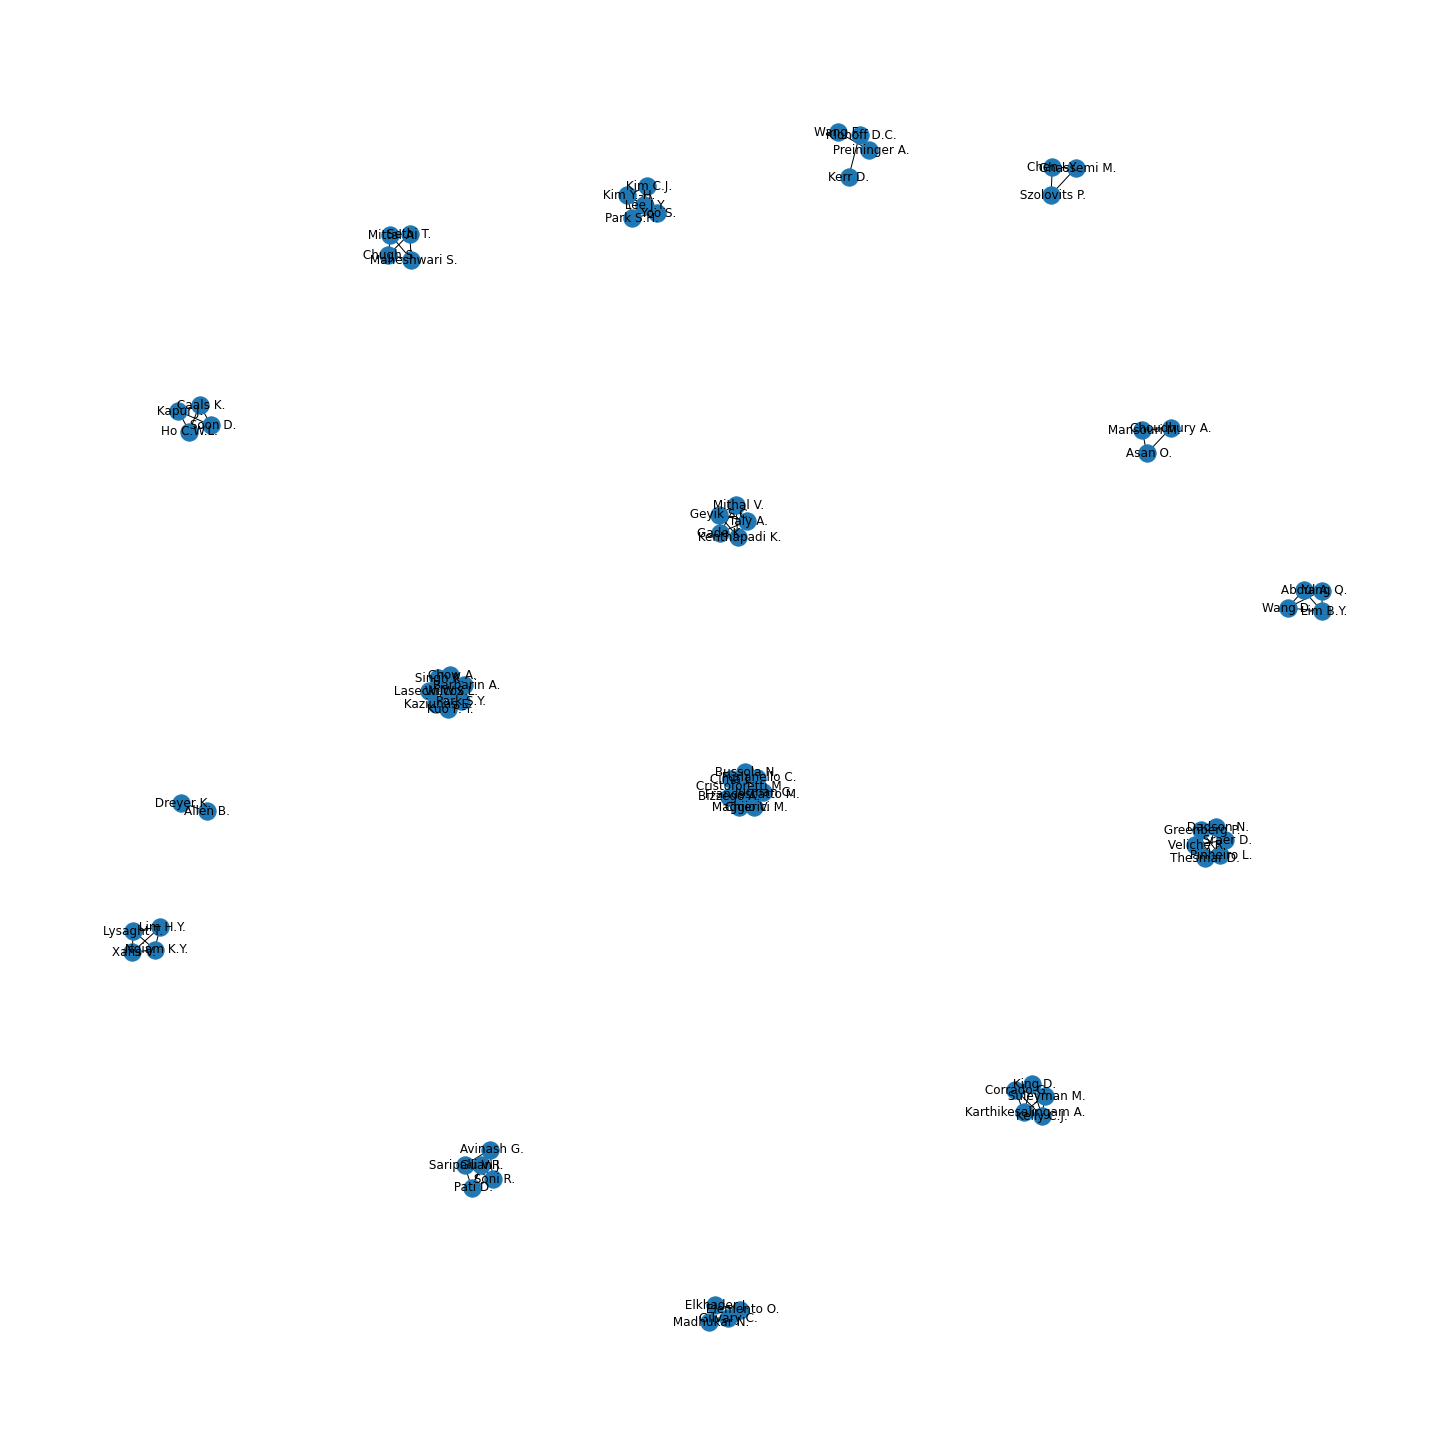

In [74]:
plt.figure(figsize = (20, 20))
nx.draw(G_2019, with_labels=True)

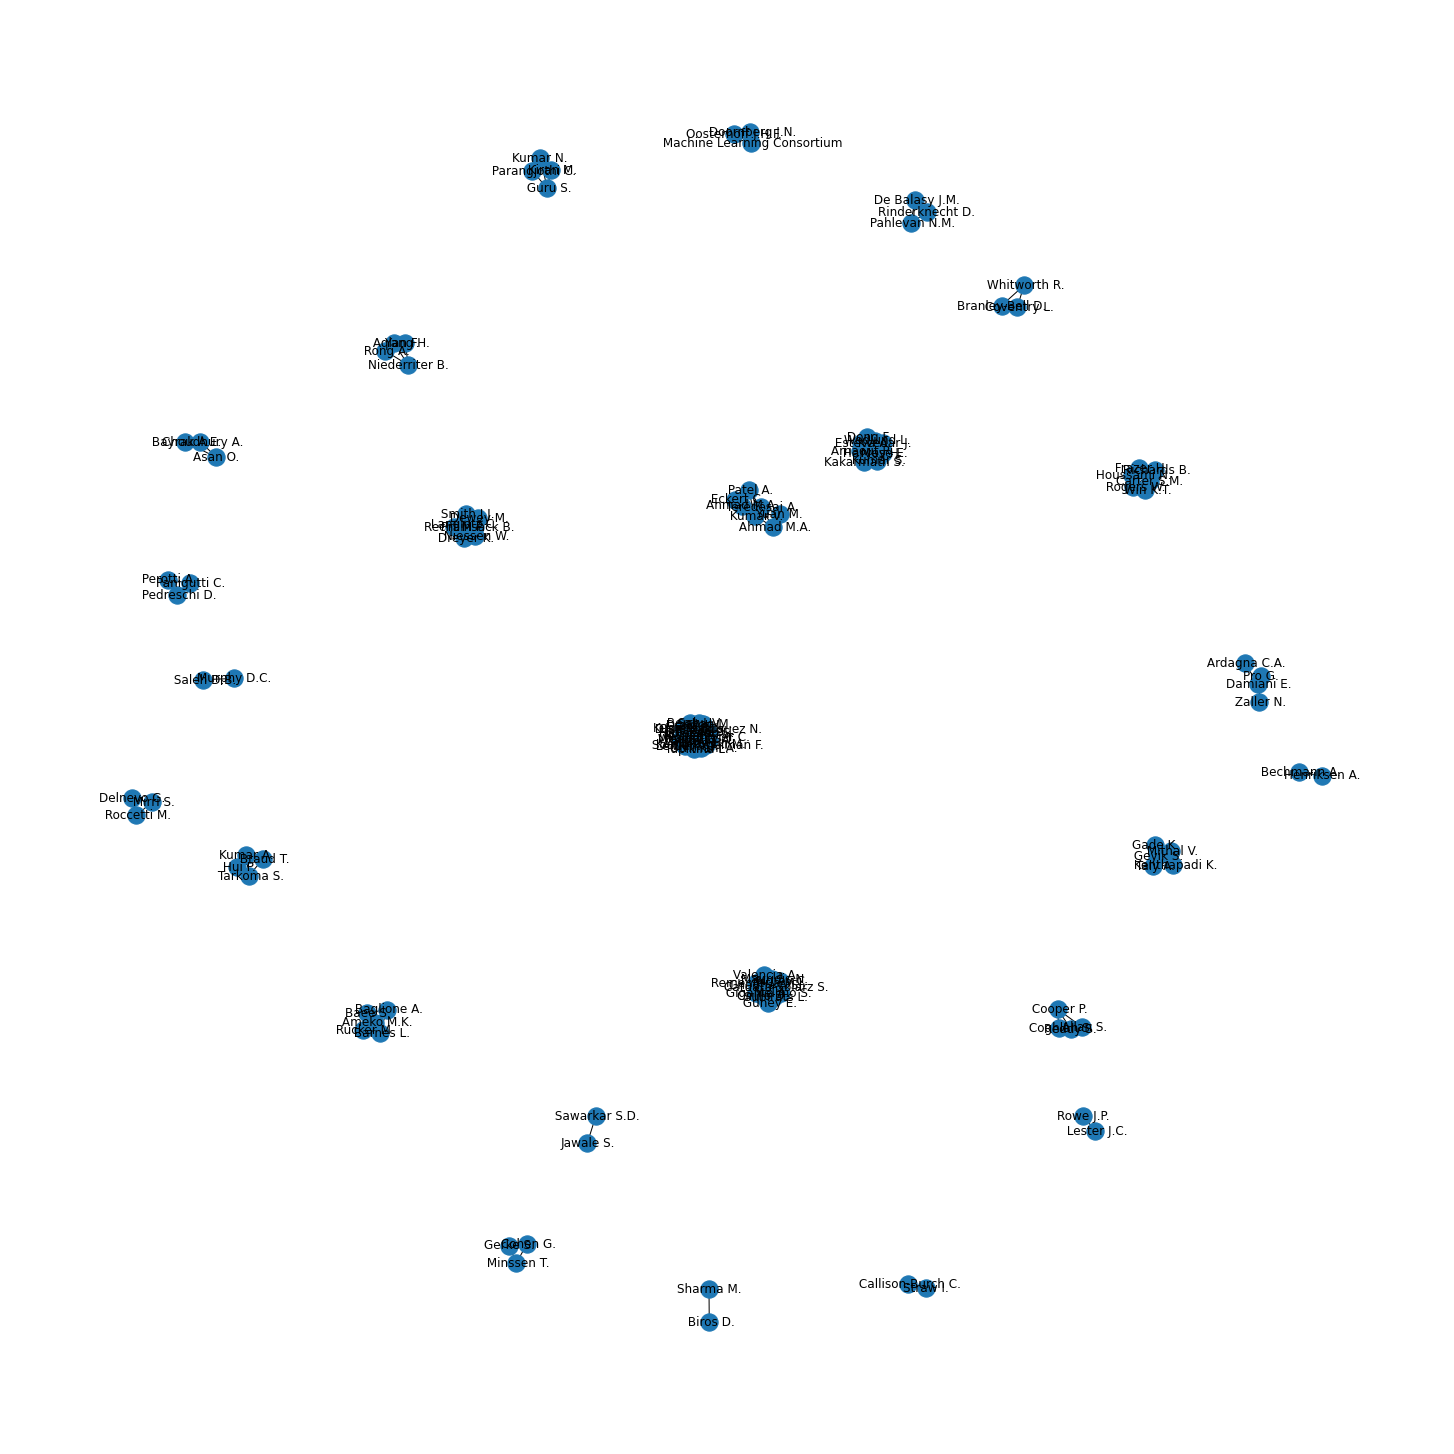

In [75]:
plt.figure(figsize = (20, 20))
nx.draw(G_2020, with_labels=True)

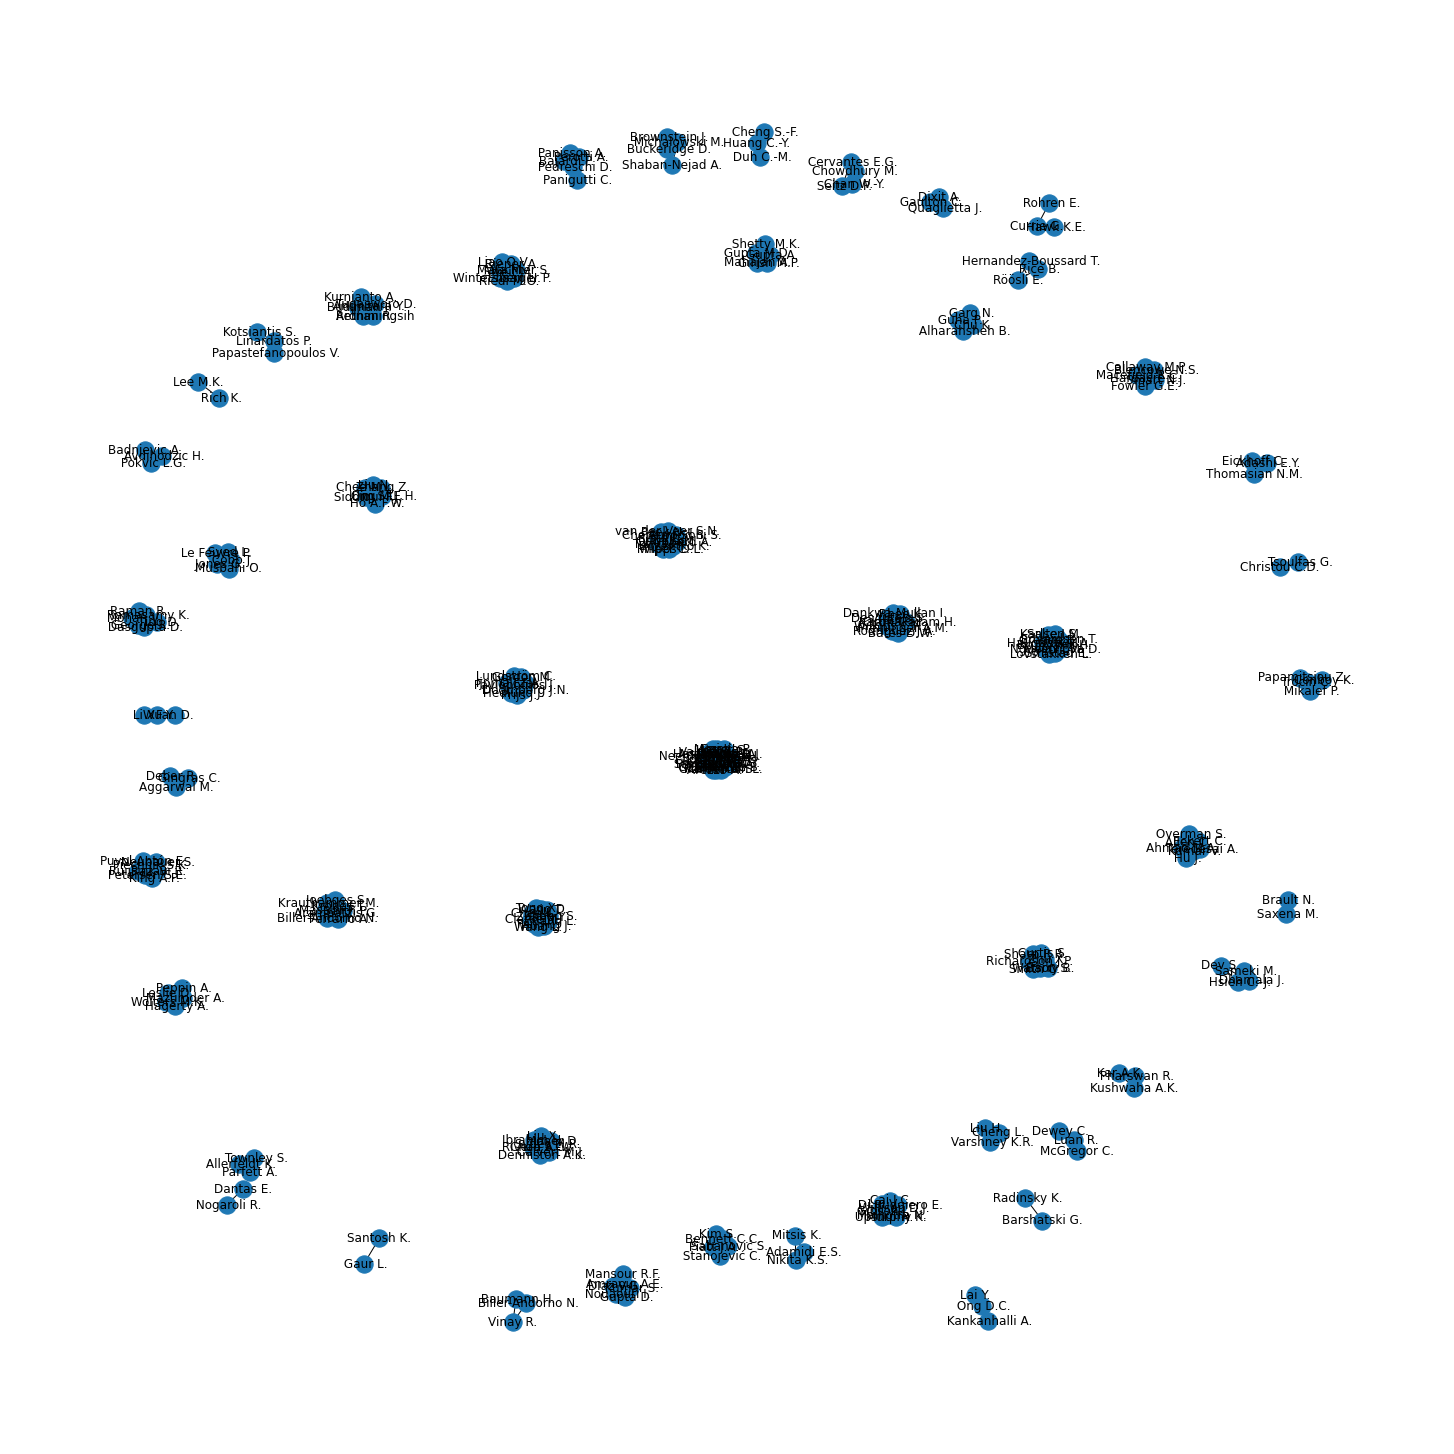

In [76]:
plt.figure(figsize = (20, 20))
nx.draw(G_2021, with_labels=True)

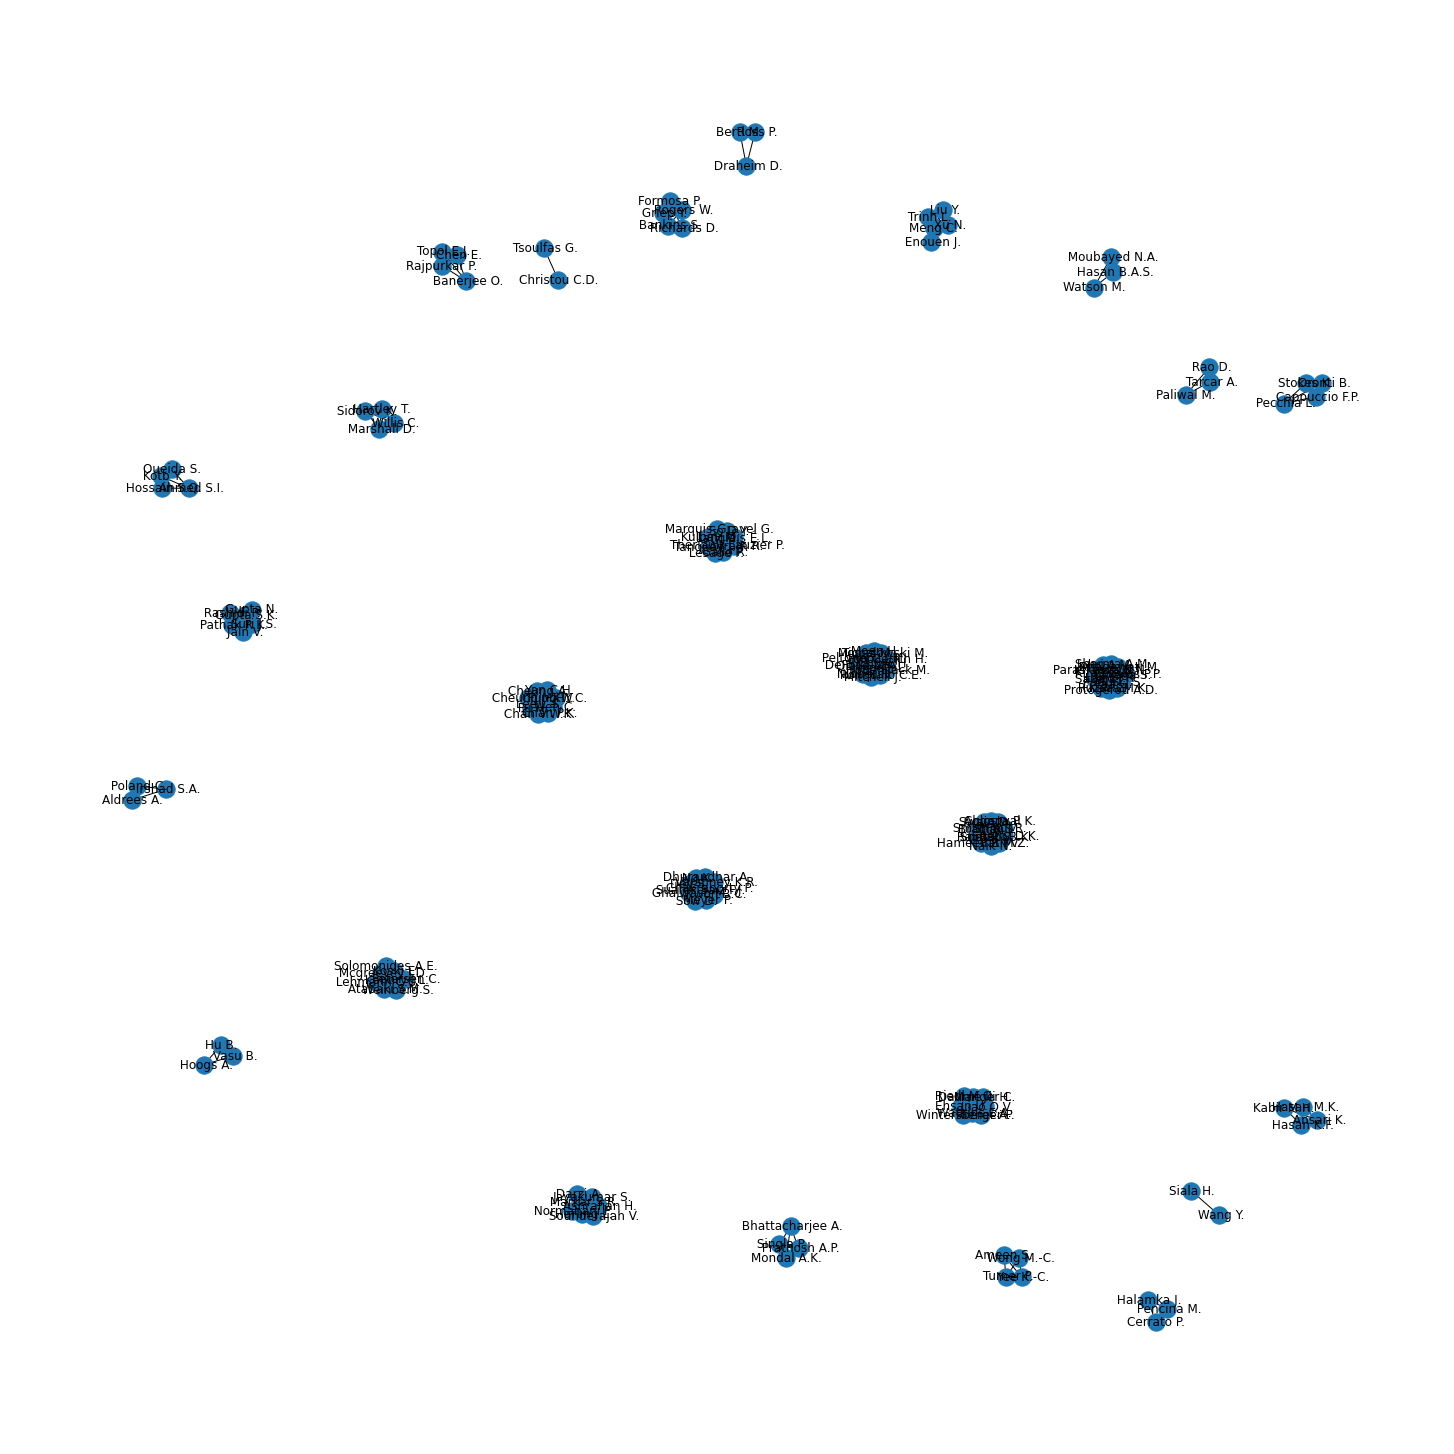

In [77]:
plt.figure(figsize = (20, 20))
nx.draw(G_2022, with_labels=True)

In [78]:
graphs = [G_2018, G_2019, G_2020, G_2021, G_2022]
for graph in graphs:
    print('Number of components in {}: {}'.format(graph, nx.number_connected_components(graph)))

Number of components in Graph with 15 nodes and 39 edges: 3
Number of components in Graph with 75 nodes and 158 edges: 17
Number of components in Graph with 126 nodes and 468 edges: 27
Number of components in Graph with 269 nodes and 1032 edges: 50
Number of components in Graph with 163 nodes and 611 edges: 27


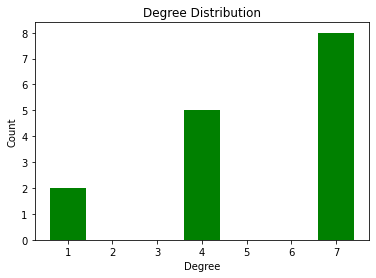

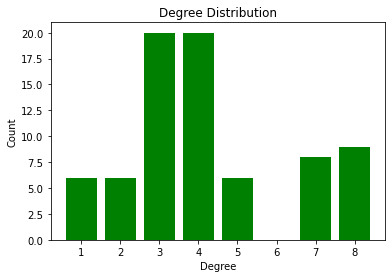

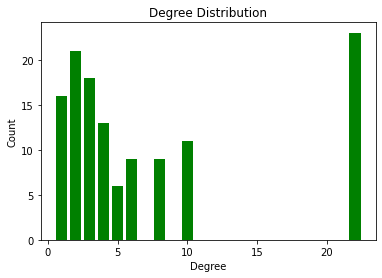

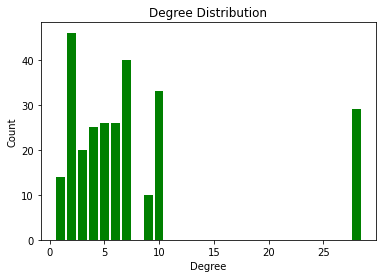

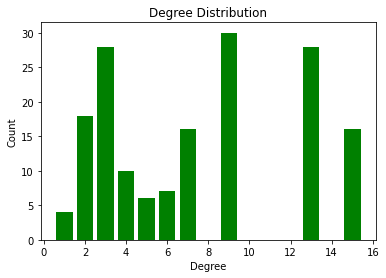

In [79]:
for g in graphs:
    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    plt.bar(deg, cnt, width=0.80, color='g')
    plt.title("Degree Distribution")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.show()